# **Dataset context**

The **IBM HR Analytics Employee Attrition & Performance** dataset provides a fictional snapshot of an organization's workforce aimed at helping HR teams and data analysts identify the factors that contribute to employee turnover and performance trends. It features both demographic and job-related variables, enabling the development of predictive models and strategic insights to improve employee retention.

# **Dataset content**
There are 1,470 observations and 35 variables, including:


*   **Age, Gender, MaritalStatus, Education, EducationField** — employee demographics

*   **Department, JobRole, BusinessTravel, OverTime** — job characteristics and work patterns

*   **DistanceFromHome, EnvironmentSatisfaction, JobSatisfaction, WorkLifeBalance, RelationshipSatisfaction** — job experience and well‑being

*   **MonthlyIncome, HourlyRate, PercentSalaryHike, StockOptionLevel** — compensation info

*   **TotalWorkingYears, YearsAtCompany, YearsInCurrentRole, YearsSinceLastPromotion, YearsWithCurrManager, NumCompaniesWorked, TrainingTimesLastYear** — career progression & training metrics
*   **PerformanceRating, JobInvolvement** — performance indicators

*   **DailyRate, MonthlyRate, StandardHours, EmployeeCount, EmployeeNumber, Over18** — various administrative identifiers; some hold constant values and are often dropped during preprocessing

*   **Attrition** — the target variable: whether the employee left (“Yes”/“No”)

*(source: https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset)*


In [1]:
!pip install -r requirements.txt --quiet

In [2]:
# Standard library imports
import os
import pickle
import warnings
from typing import Dict, Any

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn preprocessing and model selection
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Imbalanced-learn preprocessing
import imblearn
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

# Classifiers
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier
)
import xgboost
from xgboost import XGBClassifier
import catboost
from catboost import CatBoostClassifier

# Metrics and evaluation
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)
from sklearn.metrics._plot.precision_recall_curve import precision_recall_curve

# Model persistence
import joblib
from joblib import dump, load

# Suppress warnings
warnings.filterwarnings('ignore')

os.environ['OMP_NUM_THREADS']='1'

# **Functions**

In [3]:
def crosstab_categorical(df: pd.DataFrame) -> None:
    """Print crosstabs of 'Attrition' vs. each categorical column in df_cat_col."""
    for col in df_cat_col:
        print(pd.crosstab(df['Attrition'], df[col]))

In [4]:
def cap_upper_iqr(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    """
    Caps only the upper outliers in specified columns using the IQR method.
    """
    df_capped = df.copy()
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        upper_bound = Q3 + 1.5 * IQR
        df_capped[col] = df[col].clip(upper=upper_bound)  # No lower bound applied
    return df_capped

In [5]:
def get_feature_importance_df(
    pipeline: SklearnPipeline,
    preprocessor: ColumnTransformer
) -> pd.DataFrame:
    """
    Extracts feature importances from a model pipeline.
    """
    model: BaseEstimator = pipeline.named_steps['model']
    feature_names = []

    for name, transformer, columns in preprocessor.transformers_:
        if name != 'remainder':
            if hasattr(transformer, 'get_feature_names_out'):
                transformed_names = transformer.get_feature_names_out(columns)
            else:
                transformed_names = columns
            feature_names.extend(transformed_names)

    importances = model.feature_importances_

    return pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

In [6]:
def compute_classification_metrics(y_train, y_pred_tr, y_test, y_pred):
    """
    Calculate key classification metrics for train and test data.
    Returns a dictionary with confusion matrix, accuracy, precision,
    recall, F1 score, ROC AUC, and average precision.
    """
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    metrics = {
        'confusion_matrix': (tn, fp, fn, tp),
        'accuracy_train': accuracy_score(y_train, y_pred_tr),
        'accuracy_test': accuracy_score(y_test, y_pred),
        'precision_train': precision_score(y_train, y_pred_tr, average='binary'),
        'precision_test': precision_score(y_test, y_pred, average='binary'),
        'recall_train': recall_score(y_train, y_pred_tr),
        'recall_test': recall_score(y_test, y_pred),
        'f1_train': f1_score(y_train, y_pred_tr),
        'f1_test': f1_score(y_test, y_pred),
        'roc_auc_test': roc_auc_score(y_test, y_pred),
        'average_precision_test': average_precision_score(y_test, y_pred)
    }

    return metrics

In [7]:
def plot_roc_curve(model, X_test, y_test) -> None:
    """
    Display ROC curve for a trained classifier.
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax)
    plt.show()

In [8]:
def plot_precision_recall_curve(model, X_test, y_test) -> None:
    """
    Plot the Precision-Recall curve with average precision.
    """
    y_scores = model.predict_proba(X_test)[:, 1]
    prec, rec, _ = precision_recall_curve(y_test, y_scores)
    avg_precision = average_precision_score(y_test, y_scores)

    plt.figure(figsize=(12, 7))
    plt.plot(rec, prec, label=f'Average precision-recall score: {avg_precision:.2f}')
    plt.title('Precision-Recall Curve', size=20)
    plt.xlabel('Recall', size=14)
    plt.ylabel('Precision', size=14)
    plt.legend()
    plt.show()

In [9]:
def create_model_summary_row(model_name: str, metrics: Dict[str, Any]) -> Dict[str, Any]:
    """
    Create a summary dictionary for classification model performance.
    """
    tn, fp, fn, tp = metrics['confusion_matrix']

    return {
        'model': model_name,
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'correct': tp + tn,
        'incorrect': fp + fn,
        'accuracy_train': metrics['accuracy_train'],
        'accuracy_test': metrics['accuracy_test'],
        'precision_train': metrics['precision_train'],
        'precision_test': metrics['precision_test'],
        'recall_train': metrics['recall_train'],
        'recall_test': metrics['recall_test'],
        'f1_train': metrics['f1_train'],
        'f1_test': metrics['f1_test'],
        'roc_auc': metrics['roc_auc_test'],
        'avg_pre': round(metrics['average_precision_test'], 3)
    }

# **Load the data**

In [10]:
#df = pd.read_csv("/content/drive/MyDrive/WA_Fn-UseC_-HR-Employee-Attrition.csv")
df = pd.read_csv("./data/WA_Fn-UseC_-HR-Employee-Attrition.csv")

# **EDA**

In [11]:
# Shape of data
df.shape

(1470, 35)

In [12]:
# First 5 rows of data
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [13]:
# Last 5 rows of data
df.tail()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,4,80,0,17,3,2,9,6,0,8
1469,34,No,Travel_Rarely,628,Research & Development,8,3,Medical,1,2068,...,1,80,0,6,3,4,4,3,1,2


In [14]:
# Check duplicates - there are no duplicates
len(df[df.duplicated()])

0

In [15]:
# Columns names
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [16]:
# Data types - there are categorical and numerical columns
df.dtypes

Age                          int64
Attrition                   object
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeNumber               int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                      object
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears   

In [17]:
# Unique values in each column
pd.Series({c: df[c].unique() for c in df})

Age                         [41, 49, 37, 33, 27, 32, 59, 30, 38, 36, 35, 2...
Attrition                                                           [Yes, No]
BusinessTravel                 [Travel_Rarely, Travel_Frequently, Non-Travel]
DailyRate                   [1102, 279, 1373, 1392, 591, 1005, 1324, 1358,...
Department                   [Sales, Research & Development, Human Resources]
DistanceFromHome            [1, 8, 2, 3, 24, 23, 27, 16, 15, 26, 19, 21, 5...
Education                                                     [2, 1, 4, 3, 5]
EducationField              [Life Sciences, Other, Medical, Marketing, Tec...
EmployeeCount                                                             [1]
EmployeeNumber              [1, 2, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16,...
EnvironmentSatisfaction                                          [2, 3, 4, 1]
Gender                                                         [Female, Male]
HourlyRate                  [94, 61, 92, 56, 40, 79, 81, 67, 44,

In [18]:
# Number of unique values for each column - some columns have few unque values whereas others - almost for each row
df.nunique()

Age                           43
Attrition                      2
BusinessTravel                 3
DailyRate                    886
Department                     3
DistanceFromHome              29
Education                      5
EducationField                 6
EmployeeCount                  1
EmployeeNumber              1470
EnvironmentSatisfaction        4
Gender                         2
HourlyRate                    71
JobInvolvement                 4
JobLevel                       5
JobRole                        9
JobSatisfaction                4
MaritalStatus                  3
MonthlyIncome               1349
MonthlyRate                 1427
NumCompaniesWorked            10
Over18                         1
OverTime                       2
PercentSalaryHike             15
PerformanceRating              2
RelationshipSatisfaction       4
StandardHours                  1
StockOptionLevel               4
TotalWorkingYears             40
TrainingTimesLastYear          7
WorkLifeBa

In [19]:
# Check missing values - no missing values
sum(df.isna().sum())

0

In [20]:
# Data details
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [21]:
# Dataset is completely imbalanced - 1233 employees stayed at company vs 237 left
df['Attrition'].value_counts()

No     1233
Yes     237
Name: Attrition, dtype: int64

In [22]:
# The further distance from home, the less employees are in the company from this particular area
df['DistanceFromHome'].value_counts()

2     211
1     208
10     86
9      85
3      84
7      84
8      80
5      65
4      64
6      59
16     32
11     29
24     28
23     27
29     27
15     26
18     26
26     25
25     25
20     25
28     23
19     22
14     21
12     20
17     20
22     19
13     19
21     18
27     12
Name: DistanceFromHome, dtype: int64

In [23]:
# The most employees work at R&D Department, the least - in HR
df['Department'].value_counts()

Research & Development    961
Sales                     446
Human Resources            63
Name: Department, dtype: int64

In [24]:
# Drop columns  - no significant meaning for further analysis
# Column EmployeCount represents the amount of employees with particular EmployeeNumber - it is always 1
# Each employee is Over18
# Each emlpoyee works 80 hours - column StandardHours
df.drop(columns=['EmployeeCount', 'Over18', 'EmployeeNumber', 'StandardHours'], inplace=True)

In [25]:
# Change the type for columns to categorical
for col in ['BusinessTravel', 'Department', 'EducationField', 'JobRole', 'MaritalStatus']: 
    df[col] = df[col].astype('category')

In [26]:
# Change the type for columns to binary
df['Attrition'] = np.where(df['Attrition'] == 'Yes', 1, 0)
df['Gender'] = np.where(df['Gender'] == 'Female', 1, 0)
df['OverTime'] = np.where(df['OverTime'] == 'Yes', 1, 0)

In [27]:
# Check the details after change - less memory usage
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Age                       1470 non-null   int64   
 1   Attrition                 1470 non-null   int32   
 2   BusinessTravel            1470 non-null   category
 3   DailyRate                 1470 non-null   int64   
 4   Department                1470 non-null   category
 5   DistanceFromHome          1470 non-null   int64   
 6   Education                 1470 non-null   int64   
 7   EducationField            1470 non-null   category
 8   EnvironmentSatisfaction   1470 non-null   int64   
 9   Gender                    1470 non-null   int32   
 10  HourlyRate                1470 non-null   int64   
 11  JobInvolvement            1470 non-null   int64   
 12  JobLevel                  1470 non-null   int64   
 13  JobRole                   1470 non-null   catego

In [28]:
# Statistics for categorical data
df.describe(include='category').T

,count,unique,top,freq
BusinessTravel,1470,3,Travel_Rarely,1043
Department,1470,3,Research & Development,961
EducationField,1470,6,Life Sciences,606
JobRole,1470,9,Sales Executive,326
MaritalStatus,1470,3,Married,673


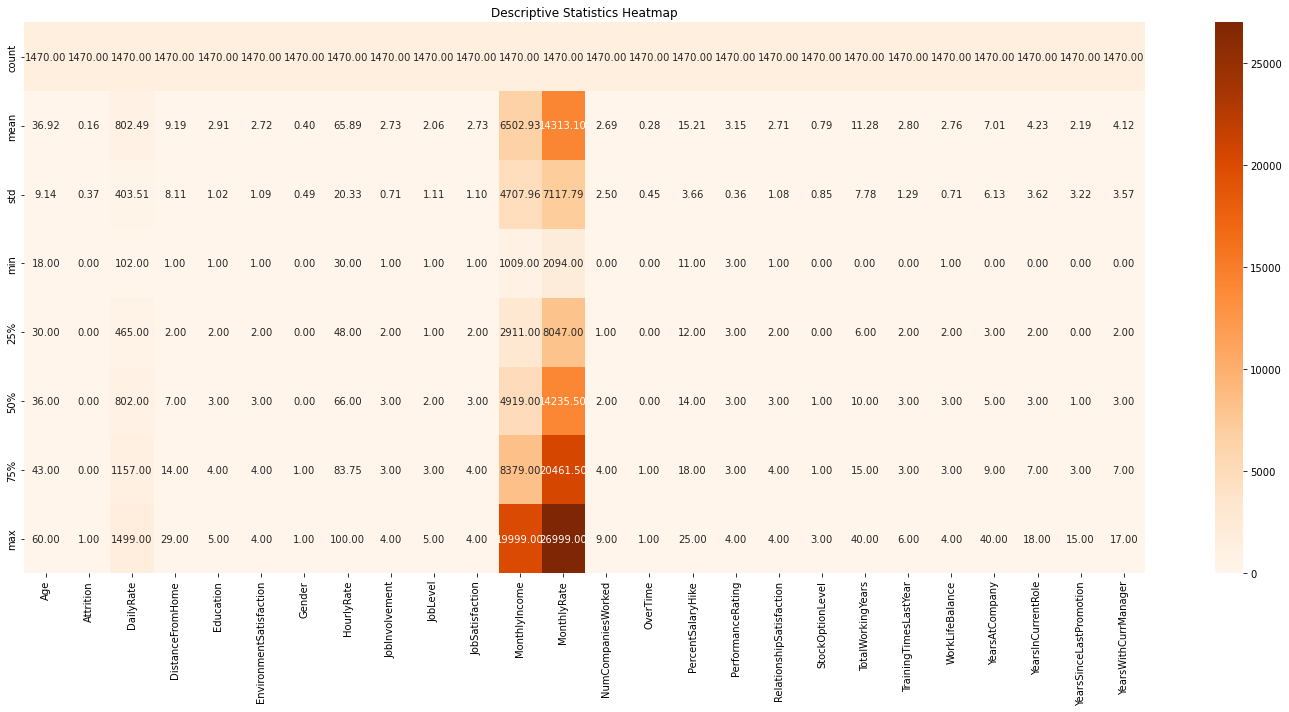

In [29]:
# Statistics for numerical data - the highest valuesare highlighted in red
df_num_col = df.select_dtypes(exclude=['category']).columns
df_num = df[df_num_col]
desc_stats = df_num.describe()
plt.figure(figsize=(20, 10))
sns.heatmap(desc_stats, cmap='Oranges', annot=True, fmt=".2f", cbar=True)
plt.title("Descriptive Statistics Heatmap")
plt.tight_layout()
plt.show()

In [30]:
# Present cross tabs for all categorical columns separately
df_cat_col = df.select_dtypes(include=['category']).columns
crosstab_categorical(df)

BusinessTravel  Non-Travel  Travel_Frequently  Travel_Rarely
Attrition                                                   
0                      138                208            887
1                       12                 69            156
Department  Human Resources  Research & Development  Sales
Attrition                                                 
0                        51                     828    354
1                        12                     133     92
EducationField  Human Resources  Life Sciences  Marketing  Medical  Other  \
Attrition                                                                   
0                            20            517        124      401     71   
1                             7             89         35       63     11   

EducationField  Technical Degree  
Attrition                         
0                            100  
1                             32  
JobRole    Healthcare Representative  Human Resources  Laboratory Techn

In [31]:
# The percentage of employees who left and stayed
df['Attrition'] = df['Attrition'].astype(int)
print('Stay:', round(df['Attrition'].value_counts()[0] / len(df) * 100, 2), '% of the dataset')
print('Left:', round(df['Attrition'].value_counts()[1] / len(df) * 100, 2), '% of the dataset')

Stay: 83.88 % of the dataset
Left: 16.12 % of the dataset


# **Visualization**

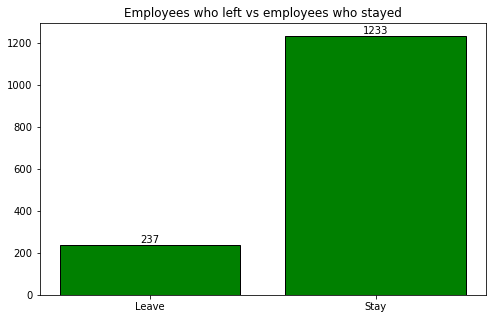

In [32]:
# Based on below bar chart for Attrition column, dataset is not well balanced (84% stay vs 16% leave)
left = (df[df['Attrition'] == 1]).count()
stay = (df[df['Attrition'] == 0]).count()
data = [left[0], stay[0]]
labels = ['Leave', 'Stay']
plt.figure(figsize=(8, 5))
plt.title('Employees who left vs employees who stayed')
bars = plt.bar(labels, data, color='green', edgecolor='black')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, str(yval), ha='center', va='bottom')
plt.show()

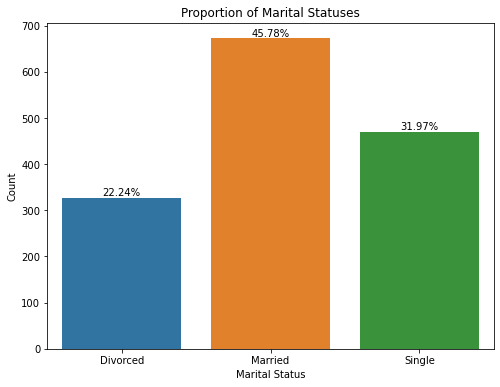

In [33]:
# The most people are married, the least - divorced
marital_status = df['MaritalStatus'].value_counts()

plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='MaritalStatus')
plt.title('Proportion of Marital Statuses')
plt.xlabel('Marital Status')
plt.ylabel('Count')

total = len(df['MaritalStatus'])
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')
plt.show()

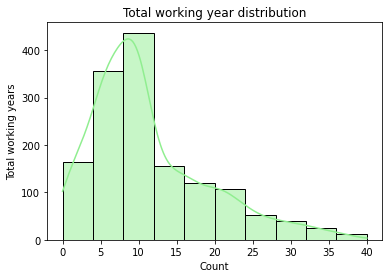

In [34]:
# Total working years distribution
sns.histplot(df['TotalWorkingYears'], kde=True, bins=10, color='lightgreen')
plt.title("Total working year distribution")
plt.xlabel('Count')
plt.ylabel('Total working years')
plt.show()

*   The distribution is not symmetric - it has long tail to the right - most employees have fewer years of experience, while a few have a lot.
*   The most common total working experience falls in the 8-10 year range - workforce consisted of mid-career professionals.
*   The count drop significantly after 15 years of experience - it is possible that fewer employees stay in the company long enough to reach higher salary.
*   Very experienced people are very rare in the company.

<AxesSubplot:>

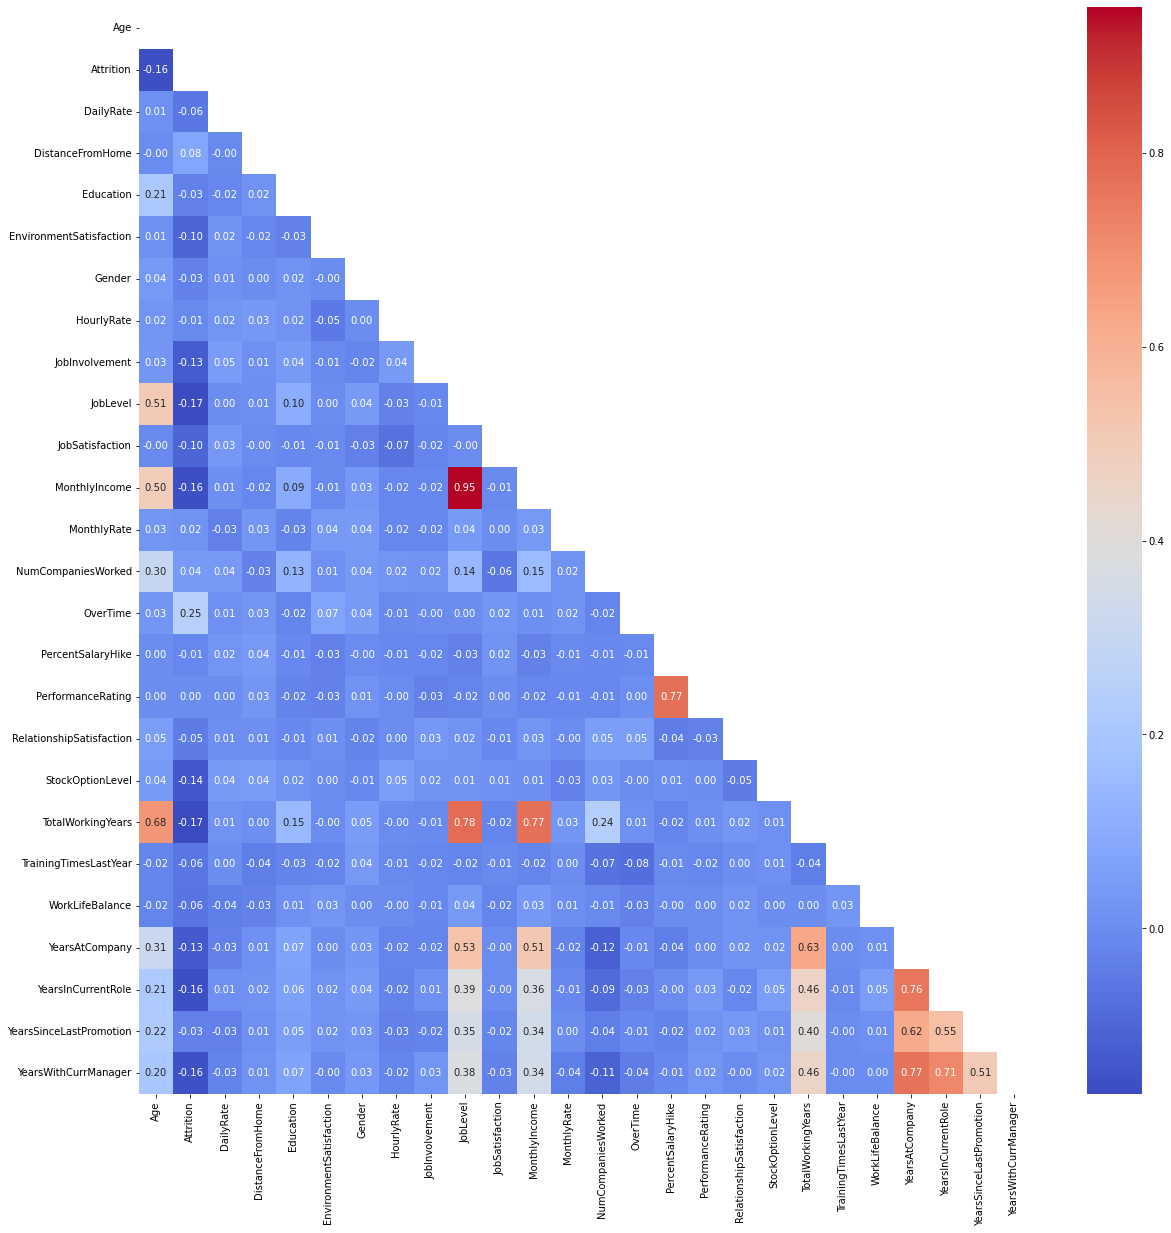

In [35]:
# Plot numeric correlation with heatmap
corr = df.select_dtypes(exclude=['category']).corr()
plt.figure(figsize=(20, 20))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot = True, mask=mask, cmap = 'coolwarm', fmt = ".2f")

## **Remarks for correlation with Attrition column**

*   JobInvolvement has one of the moderate negative correlaction wit attrition level at -0.13.
*   Changes in attrition level can be explained by about 3% changes in JobLevel.
*   MonthlyIncome has negative correlation with attrition level at -0.16.
*   Changes in attrition level can be explained by about 6% changes in OverTime. This correlation is the biggest.
*   StockOptionLevel, TotalWorkingYears, YearsAtCompany, YearsInCurrentRole, YearsWithCurrManager have also negative correcaltion with attrition level at -0.14, -0.17, -0.13, -0.16 and -0.16 accordingly.

## **Remarks for other correlations**

*   There is strong correlation (above 0.7) between following columns: MonthlyIncome/JobLevel, TotalWorkingYears/JobLevel, TotalWorkingYears/MonthlyIncome, PerformanceRating/PercentSalaryHike, YearsInCurrentRole/YearsAtCompany, YearsWithCurrManager/YearAtCompany, YearsWithCurrManager/YearsInCurrentRole.
*   However, one correlation is extremly high - between MonthlyIncome and JobLevel. Due to this fact, MonthlyIncome column will be eliminated from further analysis to make the form filled quicker.
* Columns:
 - NumCompaniesWorked, abs correlation 0.04
 - Education, Gender, YearsSinceLastPromotion, abs correlation 0.03
 - MonthlyRate, abs correlation 0.02
 - HourlyRate, PercentSalaryHike, abs correlation 0.01
 - PerformanceRating, correlation 0.00

 are weakly correlated with attrition level. The model without them will be considered.





























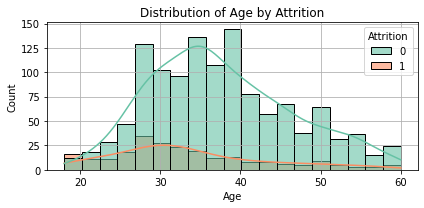

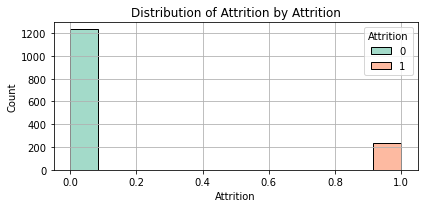

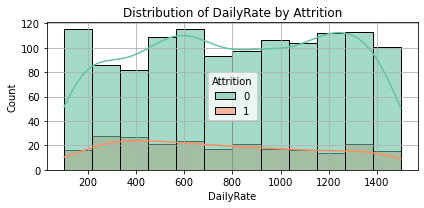

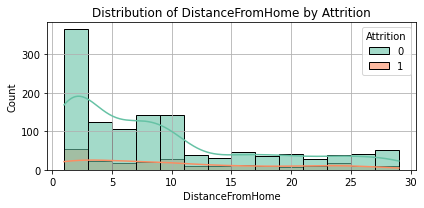

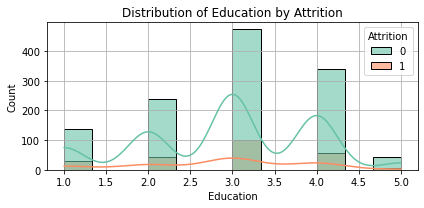

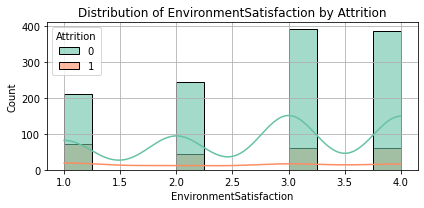

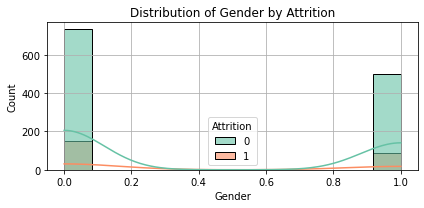

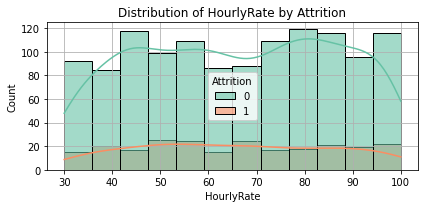

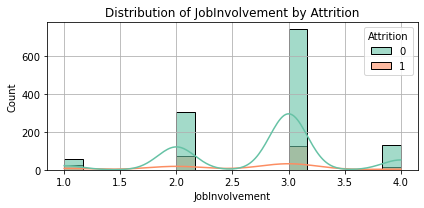

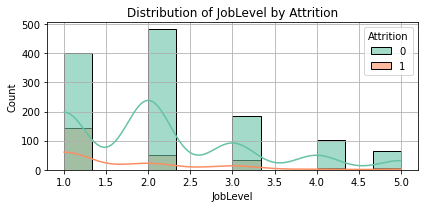

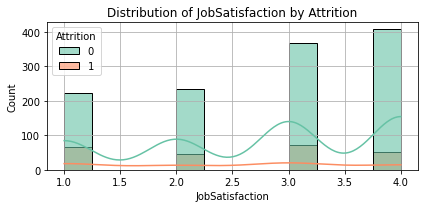

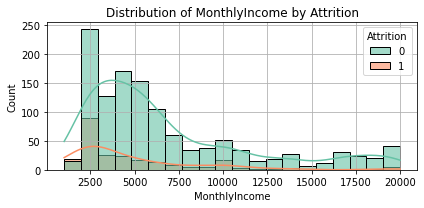

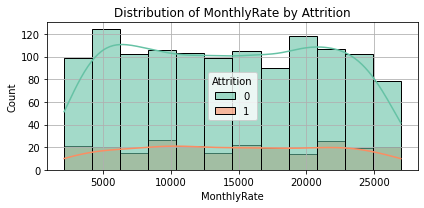

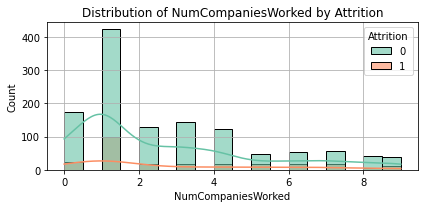

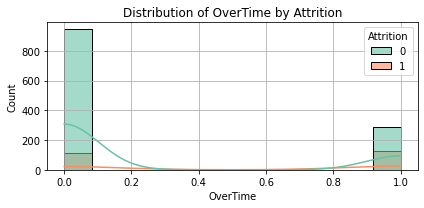

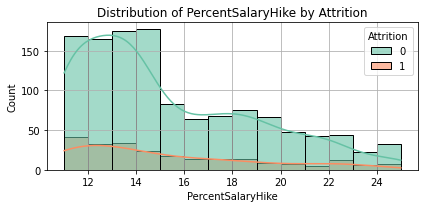

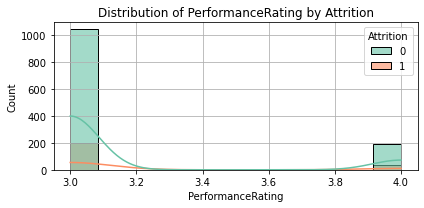

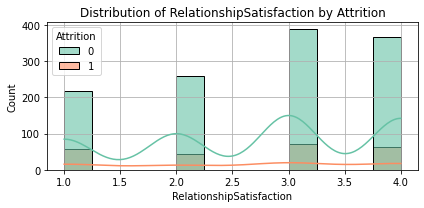

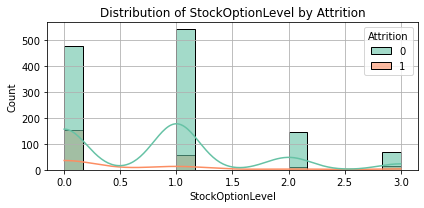

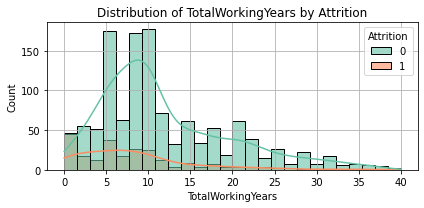

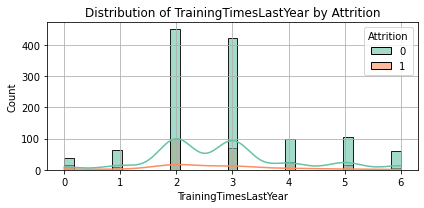

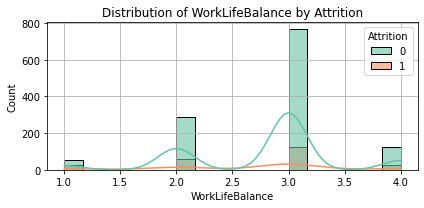

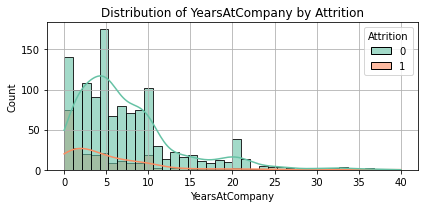

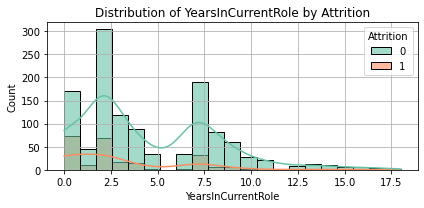

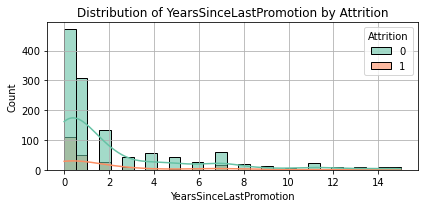

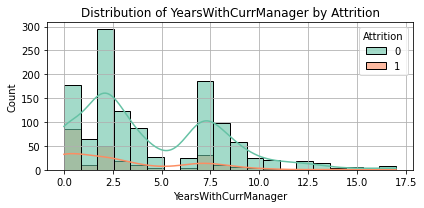

In [36]:
# Distribution plots for all numerical features
excluded_col = 'Attrition'
filtered_columns = [col for col in df_num_col if col != excluded_col]

for c in df_num_col:
    plt.figure(figsize=(6, 3))
    sns.histplot(data=df, x=c, hue=excluded_col, kde=True, stat='count', alpha=0.6, palette='Set2')
    plt.title(f"Distribution of {c} by {excluded_col}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



*  JobInvolvement - employees with medium job involvement are more likely to quit.
*  JobLevel - employees at lower job levels are more likely to leave, possibly due to lack of satisfaction, compensation or growth.
*  MonthlyIncome - workers with lower income are more prone to leave the company.
*  StockOptionLevel - no stock options might be a factor contributing to employee leaving.
*  TotalWorkingYears - less experienced employees are mote prone to leaving. They may explore career options or seek better opportunities.
*  YearsIiCurrentRole - short tenure is a red flag. It can indicate role misfit or lack of progression.
*  YearsWithCurrManager - the attrition is more possible for workers who spend less years with current manager.
*  YearsAtCompany - newer employees are at higher risk of attrition. The first few years are critical.










# **Outliers detection**

In [37]:
# Split the data into numerical and categorical columns
num_attr = df.select_dtypes(include='number').columns
cat_attr = df.select_dtypes(include='category').columns

In [38]:
cat_attr

Index(['BusinessTravel', 'Department', 'EducationField', 'JobRole',
       'MaritalStatus'],
      dtype='object')

In [39]:
# Numerical columns to be capped based on distribution on upper sight: YearsAtCompany, YearsInCurrentRole, YearsSinceLastPromotion, YearsWithCurrManager
columns = ['YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
df_capped = cap_upper_iqr(df, columns)

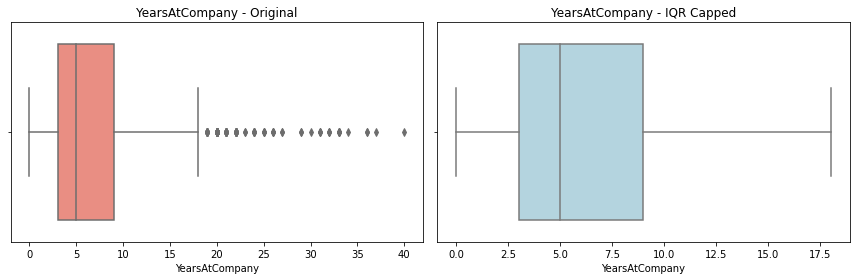

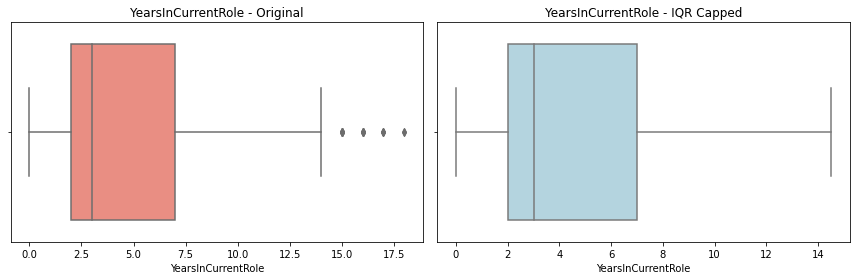

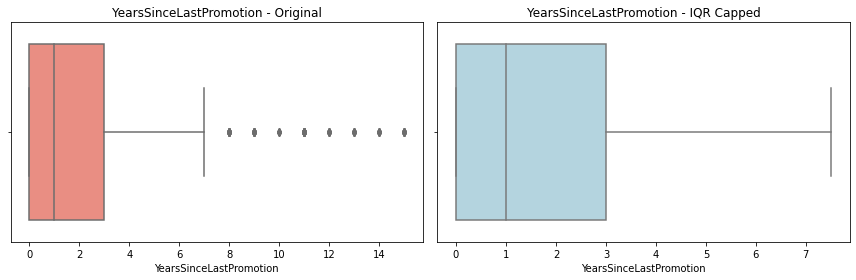

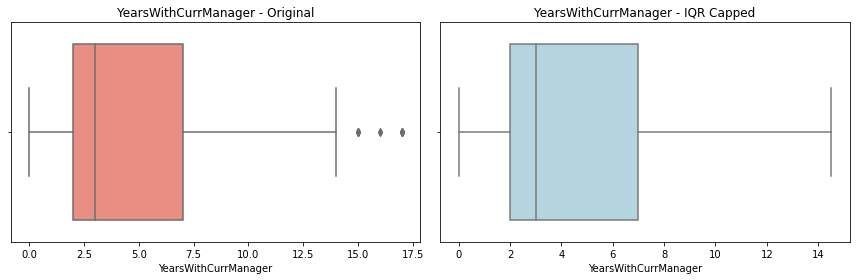

In [40]:
# The comparison for columns before and after capping
for col in columns:
    plt.figure(figsize=(12, 4))

    # Original
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df[col], color='salmon')
    plt.title(f"{col} - Original")

    # Capped
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_capped[col], color='lightblue')
    plt.title(f"{col} - IQR Capped")

    plt.tight_layout()
    plt.show()

## **Remarks for possible outliers**


*   Columns YearsAtCompany, YearsInCurrentRole, YearsSinceLastPromotion, YearsWithCurrentManager might have outliers.
* The outliers are floored using first and third quartile for extreme value.  Thanks to this operation for upper bound, the outliers are reduced without removing rows and the dataset size remains constant.


# **Feature Engineering**

In [41]:
# Dataset without MonthlyIncome and other weekly correlated with attrition features
df_shrink = df.drop(columns=['MonthlyIncome', 'NumCompaniesWorked', 'Education', 'Gender', 'YearsSinceLastPromotion', 'MonthlyRate', 'HourlyRate', 'PercentSalaryHike', 'PerformanceRating'])
df_shrink.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'EducationField', 'EnvironmentSatisfaction',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'OverTime', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsWithCurrManager'],
      dtype='object')

In [42]:
# Verify categorical and numerical attributes content for original dataset
print('Numerical attributes:', num_attr)
print('Categorical attributes:', cat_attr)

Numerical attributes: Index(['Age', 'Attrition', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate',
       'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')
Categorical attributes: Index(['BusinessTravel', 'Department', 'EducationField', 'JobRole',
       'MaritalStatus'],
      dtype='object')


In [43]:
# Split the shrink data into numerical and categorical columns
num_attr_shrink = df_shrink.select_dtypes(include='number').columns
cat_attr_shrink = df_shrink.select_dtypes(include='category').columns

In [44]:
# Verify categorical and numerical attributes content for shrink dataset
print('Numerical attributes:', num_attr_shrink)
print('Categorical attributes:', cat_attr_shrink)

Numerical attributes: Index(['Age', 'Attrition', 'DailyRate', 'DistanceFromHome',
       'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'OverTime', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsWithCurrManager'],
      dtype='object')
Categorical attributes: Index(['BusinessTravel', 'Department', 'EducationField', 'JobRole',
       'MaritalStatus'],
      dtype='object')


In [45]:
# Column transformer to preprocess numeric and categorical columns
excluded_column = 'Attrition'
num_attr_except_one = [col for col in num_attr if col != excluded_column]
all_attr = list(num_attr) + list(cat_attr)

num_attr_shrink_except_one = [col for col in num_attr_shrink if col != excluded_column]
all_attr_shrink = list(num_attr_shrink) + list(cat_attr_shrink)

In [46]:
# Column transformer to preprocess numeric and categorical columns
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_attr_except_one),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_attr)
])

preprocessor_shrink = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_attr_shrink_except_one),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_attr_shrink)
])

In [47]:
# Function to get pipeline with any model
def get_model_pipeline(model):
    return SklearnPipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

# **Modellling for original dataset**

In [48]:
# Retrieving columns which will represent independent/dependent variables
X = df.drop(['Attrition'], axis = 1)
y = df[['Attrition']]

In [49]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=True, stratify=y, random_state = 111)

## **Logistic Regression model**

Confusion matrix for train set: 


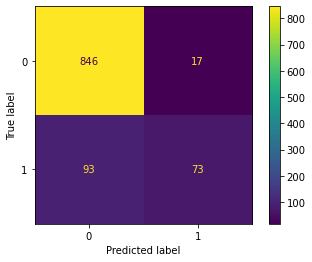

In [50]:
# Logistic regression model
model_1 = get_model_pipeline(LogisticRegression())
model_1.fit(X_train, y_train)

# Model performance evaluation for test and train set
y_pred = model_1.predict(X_test)
y_pred_tr = model_1.predict(X_train)

# Confusion matrix for train set
print("Confusion matrix for train set: ")
ConfusionMatrixDisplay.from_estimator(model_1, X_train, y_train)

Confusion matrix for test set: 


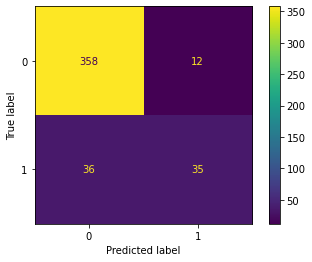

In [51]:
# Confusion matrix for test set
print("Confusion matrix for test set: ")
ConfusionMatrixDisplay.from_estimator(model_1, X_test, y_test)

In [52]:
# Classification report for test set
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       370
           1       0.74      0.49      0.59        71

    accuracy                           0.89       441
   macro avg       0.83      0.73      0.77       441
weighted avg       0.88      0.89      0.88       441



In [53]:
# Classification report for train set
print(classification_report(y_train, y_pred_tr))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       863
           1       0.81      0.44      0.57       166

    accuracy                           0.89      1029
   macro avg       0.86      0.71      0.75      1029
weighted avg       0.89      0.89      0.88      1029



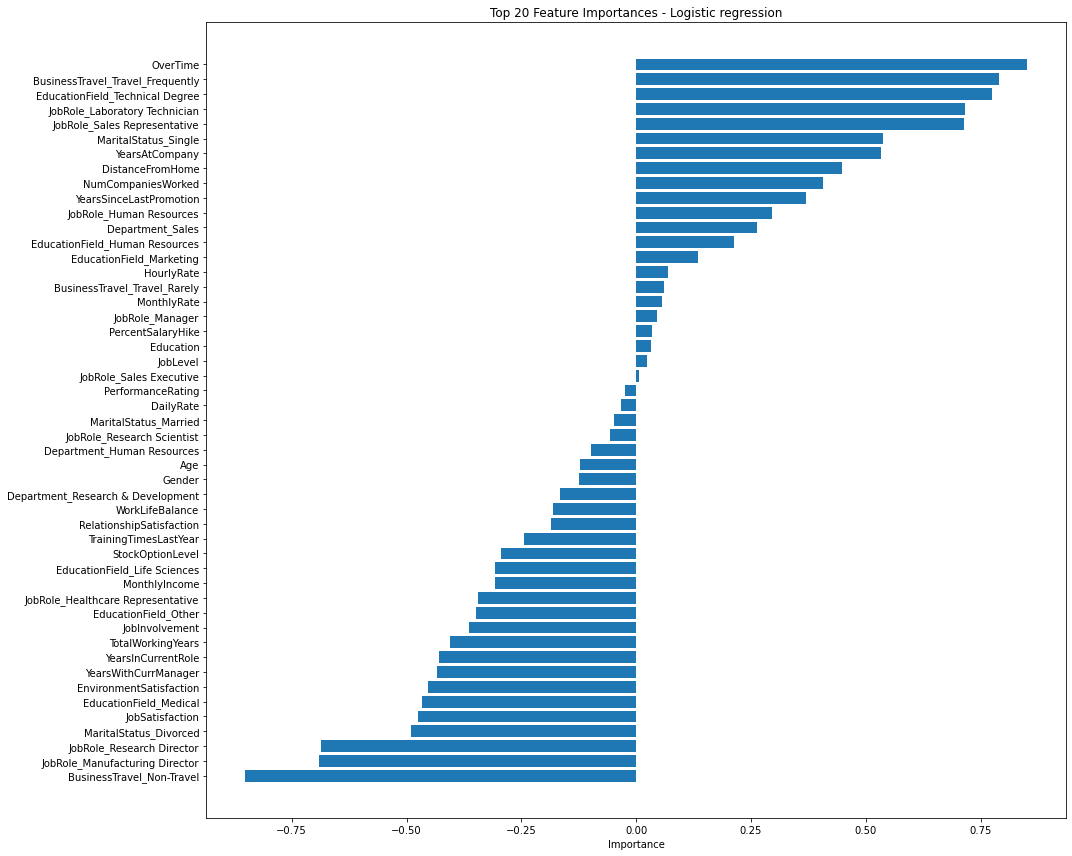

In [54]:
feature_names = []

# Extract feature names from each transformer in the ColumnTransformer
for name, transformer, columns in preprocessor.transformers_:
    if name != 'remainder':
        if hasattr(transformer, 'get_feature_names_out'):
            transformed_names = transformer.get_feature_names_out(columns)
        else:
            transformed_names = columns
        feature_names.extend(transformed_names)

m1 = model_1.named_steps['model']
importances = m1.coef_[0]

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(15, 12))
plt.barh(feature_importance_df['Feature'][::-1], feature_importance_df['Importance'][::-1])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances - Logistic regression')
plt.tight_layout()
plt.show()


*  We can expect that odds of people who left the company to increase (the original coefficient is positive) for features: OverTime, BusinessTravel_Travel_Frequently, EducationField_Technical Degree, JobRole_Sales Representative, JobRole_Laboratory Technician, YearsAtCompany, MaritalStatus_Single, DistanceFromHome, NumCompaniesWorked, YearsSinceLastPromotion, JobRole_Human Resources, Department_Sales, EducationField_HumanResources, EducationField_Marketing, HourlyRate, MonthlyRate, BusinessTravel_Travel Rarely, JobRole_Manager, PercentSalaryHike, Education, JobLevel and JobRole_Sales Executive.
*   Rest features have negativel coefficients. 
*   OverTime and BusinessTravel_Non-Travel are the strongest predictors.
*   JobRole_Sales Executive and JobLevel are the weakest predictors.






In [55]:
# Gather some metrics for future comparison of models performance
metrics_1 = compute_classification_metrics(y_train, y_pred_tr, y_test, y_pred)

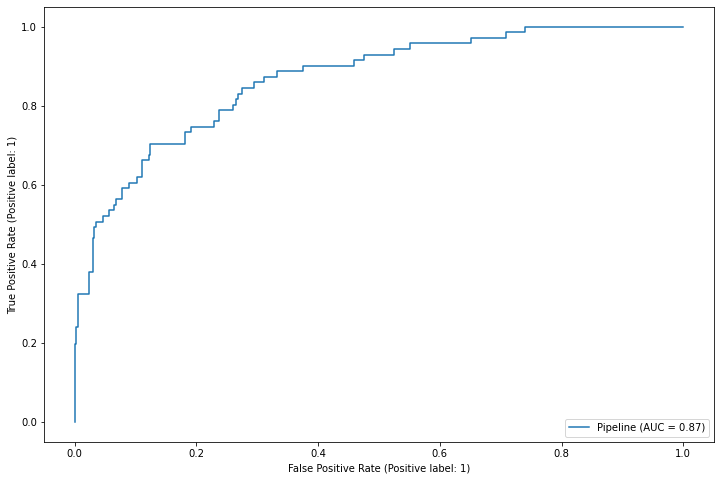

In [56]:
# ROC curve
plot_roc_curve(model_1, X_test, y_test)

AUC is 0.87 which means that there is a 87% chance that the model will be able to distinguish between positive class and negative class.

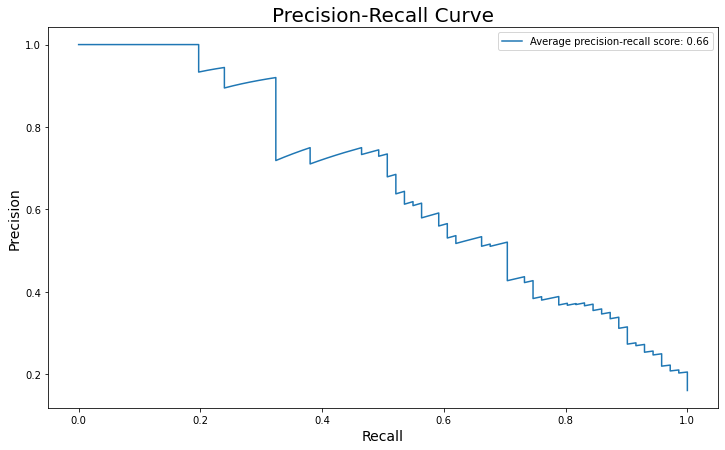

In [57]:
# Precision-Recall curve
plot_precision_recall_curve(model_1, X_test, y_test)

In [58]:
# Row with model
row_1 = create_model_summary_row("Logistic Regression", metrics_1)

## **Random Forest model**

Confusion matrix for train set: 


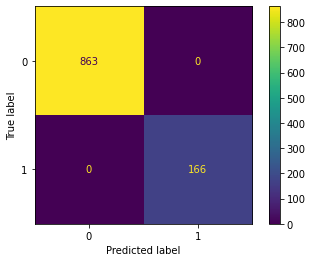

In [59]:
# Random Forest Classifier model
model_2 = get_model_pipeline(RandomForestClassifier())
model_2.fit(X_train, y_train)

# Model performance evaluation for test and train set
y_pred = model_2.predict(X_test)
y_pred_tr = model_2.predict(X_train)

# Confusion matrix for train set
print("Confusion matrix for train set: ")
ConfusionMatrixDisplay.from_estimator(model_2, X_train, y_train)

Confusion matrix for test set: 


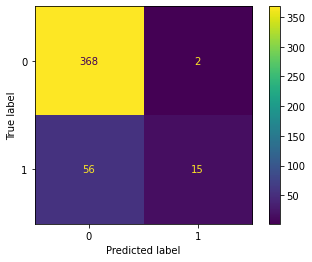

In [60]:
# Confusion matrix for test set
print("Confusion matrix for test set: ")
ConfusionMatrixDisplay.from_estimator(model_2, X_test, y_test)

In [61]:
# Classification report for test set
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.99      0.93       370
           1       0.88      0.21      0.34        71

    accuracy                           0.87       441
   macro avg       0.88      0.60      0.63       441
weighted avg       0.87      0.87      0.83       441



In [62]:
# Classification report for train set
print(classification_report(y_train, y_pred_tr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       863
           1       1.00      1.00      1.00       166

    accuracy                           1.00      1029
   macro avg       1.00      1.00      1.00      1029
weighted avg       1.00      1.00      1.00      1029



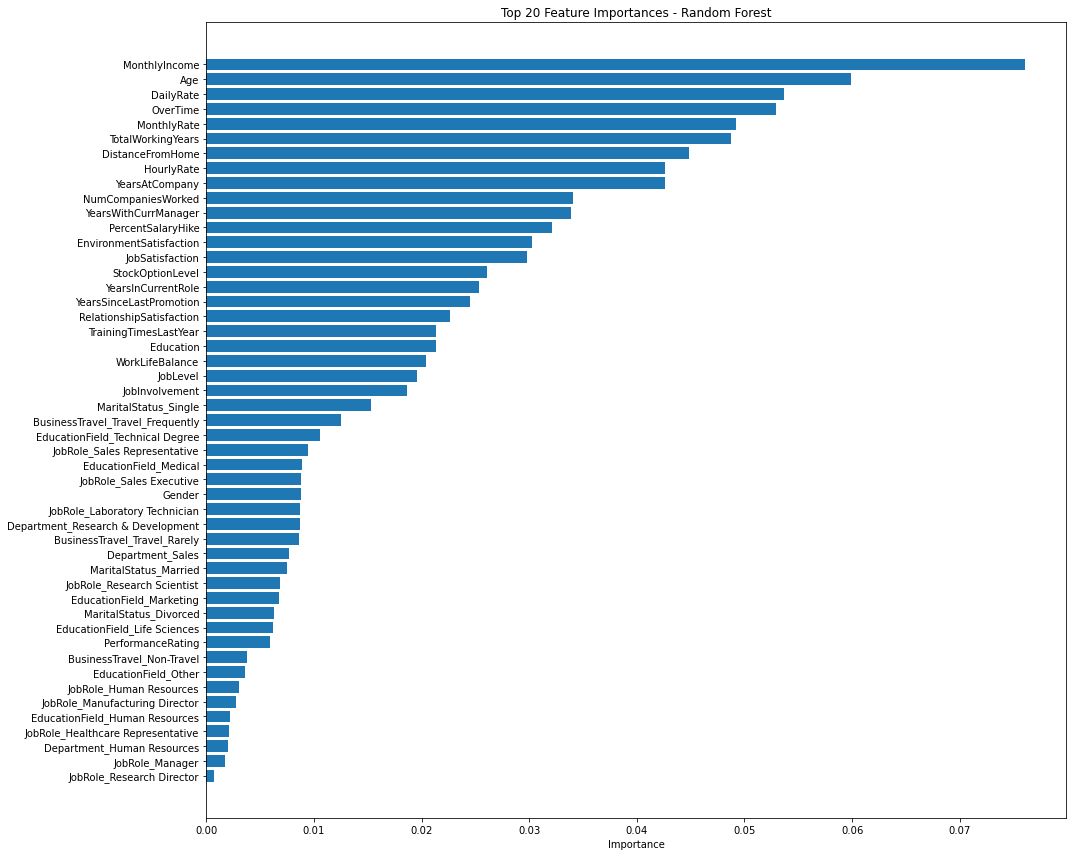

In [63]:
feature_importance_df = get_feature_importance_df(model_2, preprocessor)

# Plot
plt.figure(figsize=(15, 12))
plt.barh(feature_importance_df['Feature'][::-1], feature_importance_df['Importance'][::-1])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances - Random Forest')
plt.tight_layout()
plt.show()


*   We can expect the odds of people who left to increase (the original coefficient was positive) for all features.
*  OverTime, MonthlyIncome and Age are the strongest predictors.
*  JobRole_Research Director and JobRole_Manager are the weakest predictors.








In [64]:
# Gather some metrics for future comparison of models performance
metrics_2 = compute_classification_metrics(y_train, y_pred_tr, y_test, y_pred)

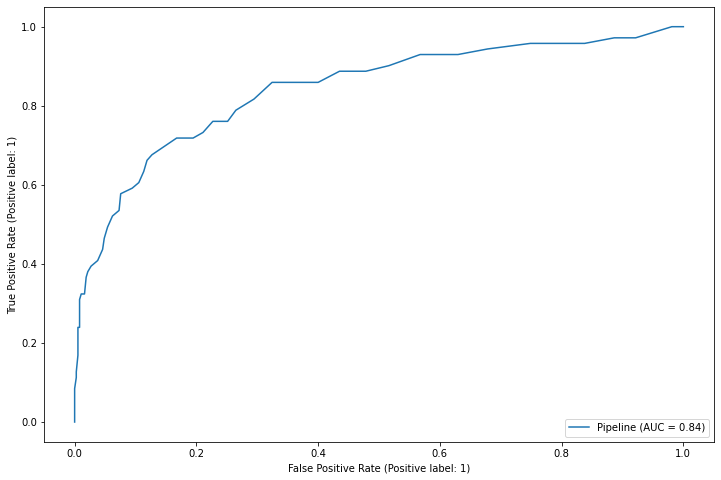

In [65]:
# ROC curve
plot_roc_curve(model_2, X_test, y_test)

AUC is 0.82 which means that there is a 82% chance that the model will be able to distinguish between positive class and negative class.

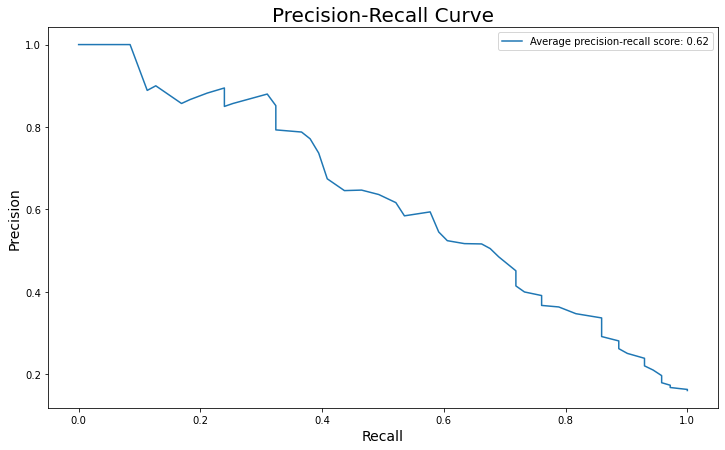

In [66]:
# Precision-Recall curve
plot_precision_recall_curve(model_2, X_test, y_test)

In [67]:
# Row with model
row_2 = create_model_summary_row("Random Forest", metrics_2)

## **Decision tree model**

Confusion matrix for train set: 


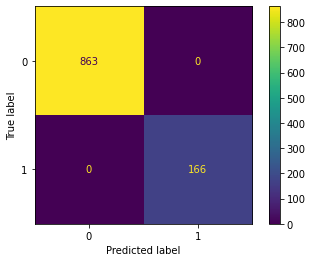

In [68]:
# DecisionTree Classifier model
model_3 = get_model_pipeline(DecisionTreeClassifier())
model_3.fit(X_train, y_train)

# Model performance evaluation for test and train set
y_pred = model_3.predict(X_test)
y_pred_tr = model_3.predict(X_train)

# Confusion matrix for train set
print("Confusion matrix for train set: ")
ConfusionMatrixDisplay.from_estimator(model_3, X_train, y_train)

Confusion matrix for test set: 


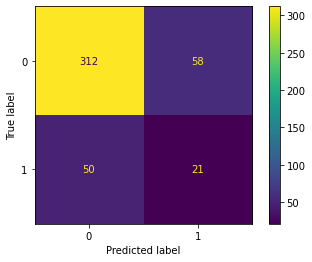

In [69]:
# Confusion matrix for test set
print("Confusion matrix for test set: ")
ConfusionMatrixDisplay.from_estimator(model_3, X_test, y_test)

In [70]:
# Classification report for test set
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85       370
           1       0.27      0.30      0.28        71

    accuracy                           0.76       441
   macro avg       0.56      0.57      0.57       441
weighted avg       0.77      0.76      0.76       441



In [71]:
# Classification report for train set
print(classification_report(y_train, y_pred_tr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       863
           1       1.00      1.00      1.00       166

    accuracy                           1.00      1029
   macro avg       1.00      1.00      1.00      1029
weighted avg       1.00      1.00      1.00      1029



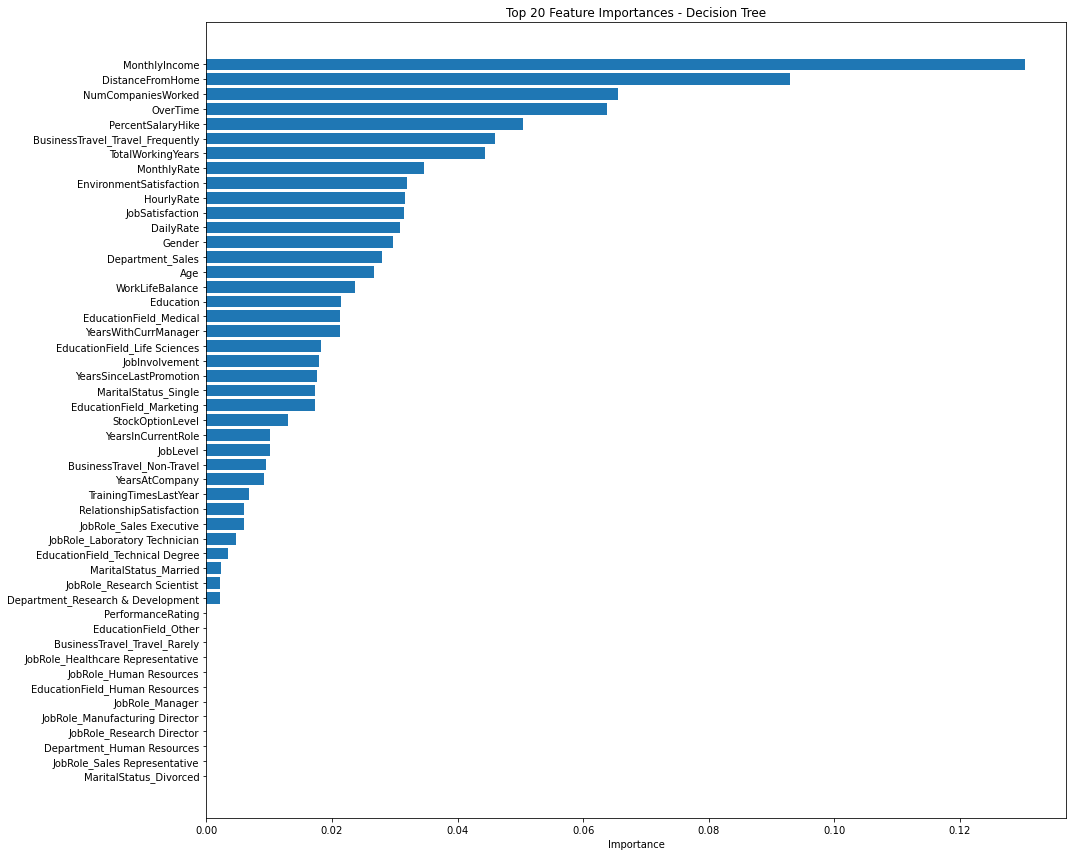

In [72]:
feature_importance_df = get_feature_importance_df(model_3, preprocessor)
# Plot
plt.figure(figsize=(15, 12))
plt.barh(feature_importance_df['Feature'][::-1], feature_importance_df['Importance'][::-1])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances - Decision Tree')
plt.tight_layout()
plt.show()


*   We can expect the odds of people who left to increase (the original coeff was positive) for most of columns.
*   Columns JobRole_Manufacturing Director, HobRole_Sales Representative, JobRole_Research Director, JobRole_Health Representative, JobRole_Manager, JobRole_Laboratory Technician, JobRole_Human Resources, EducationField_Technical Degree, EducationField_Human Resources, JobLevel, BusinessTravel_Travel_Rarely, EducationField_Other have coefficients equal to zero.
*   MonthlyIncome is the strongest predictor.

In [73]:
# Gather some metrics for future comparison of models performance
metrics_3 = compute_classification_metrics(y_train, y_pred_tr, y_test, y_pred)

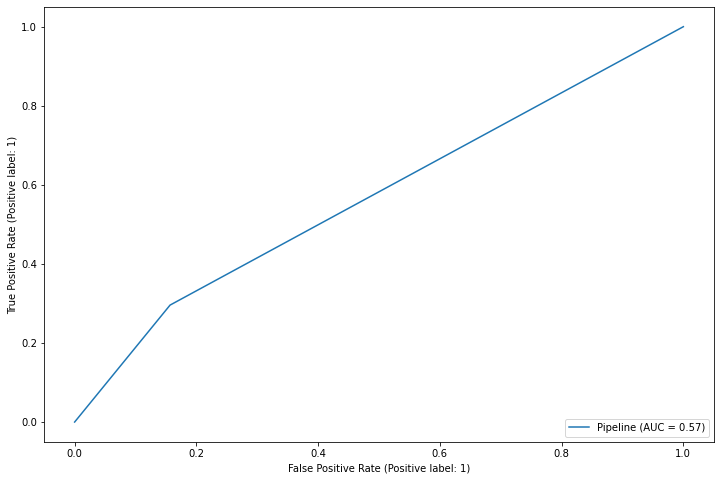

In [74]:
# ROC curve
plot_roc_curve(model_3, X_test, y_test)

AUC is 0.57 which means that there is a 57% chance that the model will be able to distinguish between positive class and negative class.

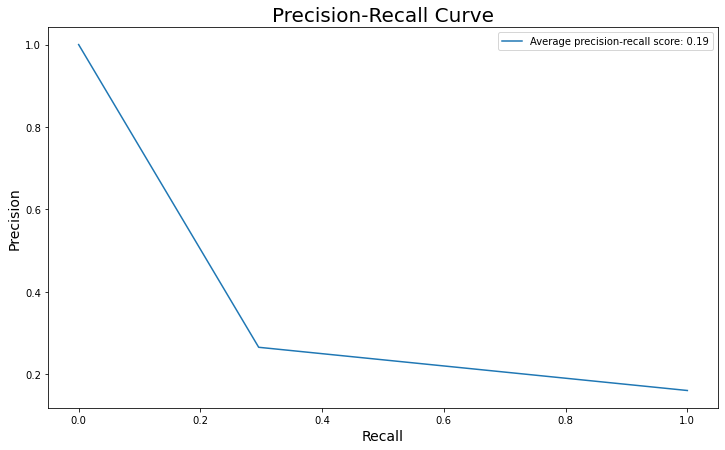

In [75]:
# Precision-Recall curve
plot_precision_recall_curve(model_3, X_test, y_test)

In [76]:
# Row with model
row_3 = create_model_summary_row("Decision Tree", metrics_3)

## **AdaBoost model**

Confusion matrix for train set: 


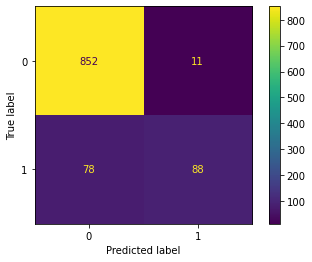

In [77]:
#  AdaBoost Classifier model
model_4 = get_model_pipeline(AdaBoostClassifier())
model_4.fit(X_train, y_train)

# Model performance evaluation for test and train set
y_pred = model_4.predict(X_test)
y_pred_tr = model_4.predict(X_train)

# Confusion matrix for train set
print("Confusion matrix for train set: ")
ConfusionMatrixDisplay.from_estimator(model_4, X_train, y_train)

Confusion matrix for test set: 


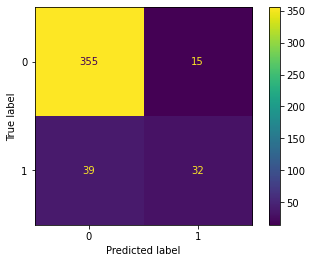

In [78]:
# Confusion matrix for test set
print("Confusion matrix for test set: ")
ConfusionMatrixDisplay.from_estimator(model_4, X_test, y_test)

In [79]:
# Classification report for test set
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       370
           1       0.68      0.45      0.54        71

    accuracy                           0.88       441
   macro avg       0.79      0.71      0.74       441
weighted avg       0.87      0.88      0.87       441



In [80]:
# Classification report for train set
print(classification_report(y_train, y_pred_tr))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       863
           1       0.89      0.53      0.66       166

    accuracy                           0.91      1029
   macro avg       0.90      0.76      0.81      1029
weighted avg       0.91      0.91      0.90      1029



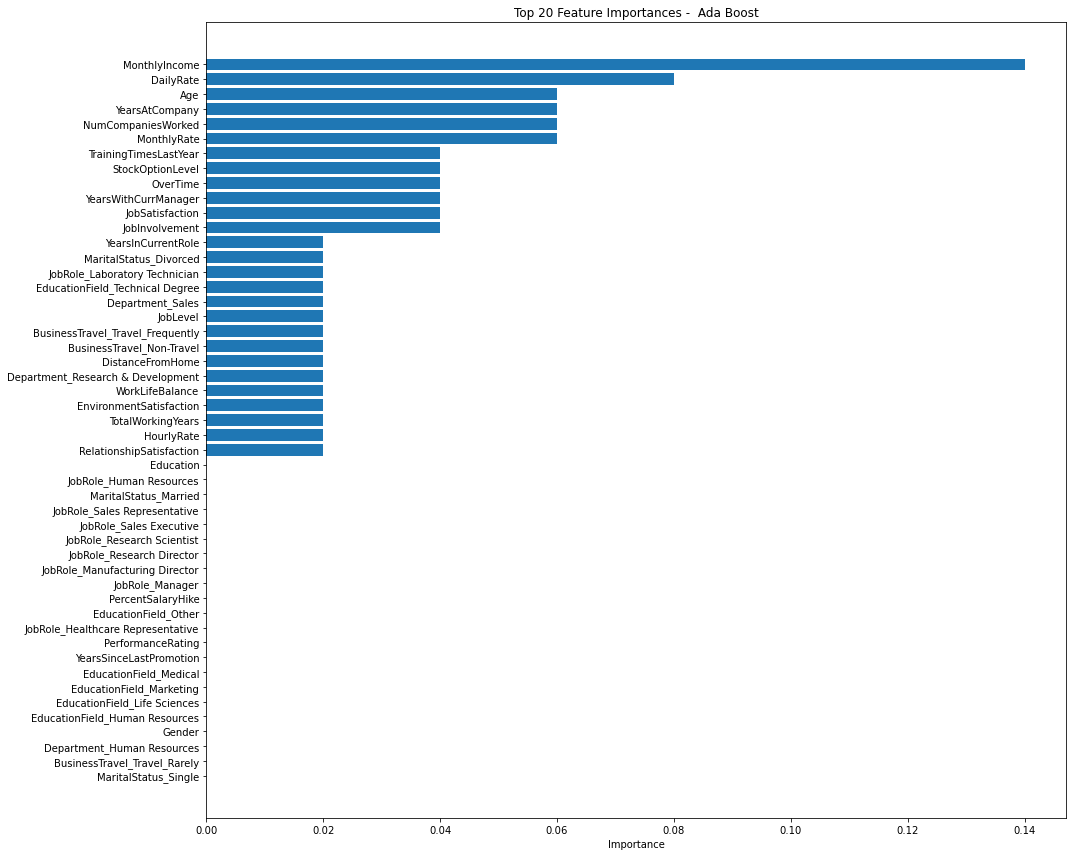

In [81]:
feature_importance_df = get_feature_importance_df(model_4, preprocessor)

# Plot
plt.figure(figsize=(15, 12))
plt.barh(feature_importance_df['Feature'][::-1], feature_importance_df['Importance'][::-1])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances -  Ada Boost')
plt.tight_layout()
plt.show()

* We can expect the odds of people who left the company to increase (the original coeff was positive) for                  OverTime, YearsWithCurrManeger, MonthlyIncome, YearsAtCompany, StockOptionLevel, HourlyRate, RelationshipSatisfaction, EnvironmentSatisfaction, Age, DistanceFromHome, Department_Research & Development, TrainingTmesLastYear, EducationField_Technical Degree, JobLevel, JobRole_Laboratory Technician, Department_Sales, BusinessTravel_Travel_Frequently, NumCompaniesWorked, BusinessTravel_Non-Travel,DailyRate,MonthlyRate, MaritalStatus_Divorced, WorkLifeBalance,TotalWorkingYears.
* Remaining features have coefficients equal to zero.
* MonthlyIncome and DailyRate are the strongest predictors.

In [82]:
# Gather some metrics for future comparison of models performance
metrics_4 = compute_classification_metrics(y_train, y_pred_tr, y_test, y_pred)

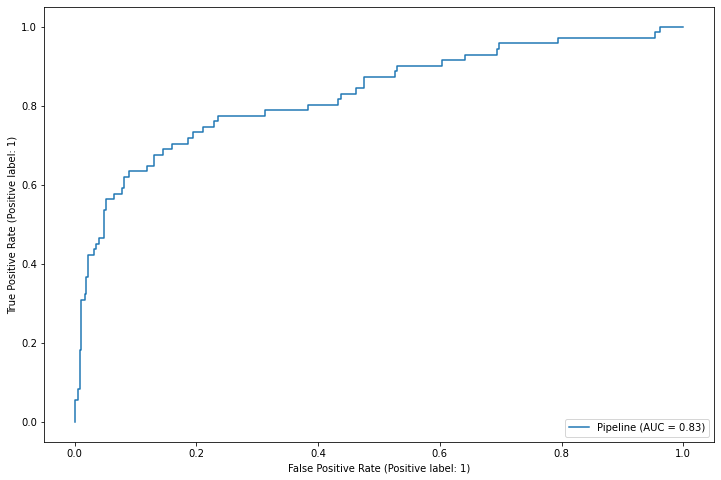

In [83]:
# ROC curve
plot_roc_curve(model_4, X_test, y_test)

AUC is 0.83 which means that there is a 83% chance that the model will be able to distinguish between positive class and negative class.

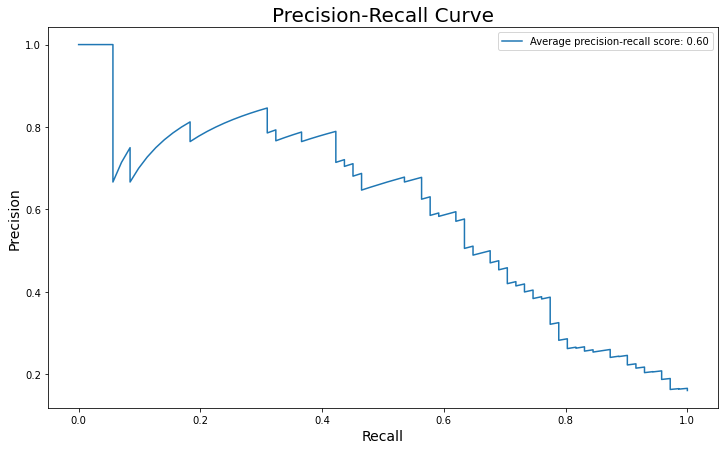

In [84]:
# Precision-Recall curve
plot_precision_recall_curve(model_4, X_test, y_test)

In [85]:
# Row with model
row_4 = create_model_summary_row("Ada Boost", metrics_4)

## **Gradient Boosting model**

Confusion matrix for train set: 


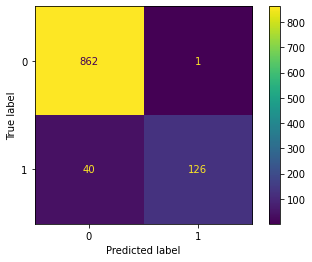

In [86]:
# Gradient Boosting model
model_5 = get_model_pipeline(GradientBoostingClassifier())
model_5.fit(X_train, y_train)

# Model performance evaluation for test and train set
y_pred = model_5.predict(X_test)
y_pred_tr = model_5.predict(X_train)

# Confusion matrix for train set
print("Confusion matrix for train set: ")
ConfusionMatrixDisplay.from_estimator(model_5, X_train, y_train)

Confusion matrix for test set: 


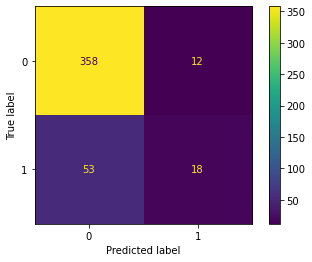

In [87]:
# Confusion matrix for test set
print("Confusion matrix for test set: ")
ConfusionMatrixDisplay.from_estimator(model_5, X_test, y_test)

In [88]:
# Classification report for test set
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       370
           1       0.60      0.25      0.36        71

    accuracy                           0.85       441
   macro avg       0.74      0.61      0.64       441
weighted avg       0.83      0.85      0.83       441



In [89]:
# Classification report for train set
print(classification_report(y_train, y_pred_tr))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       863
           1       0.99      0.76      0.86       166

    accuracy                           0.96      1029
   macro avg       0.97      0.88      0.92      1029
weighted avg       0.96      0.96      0.96      1029



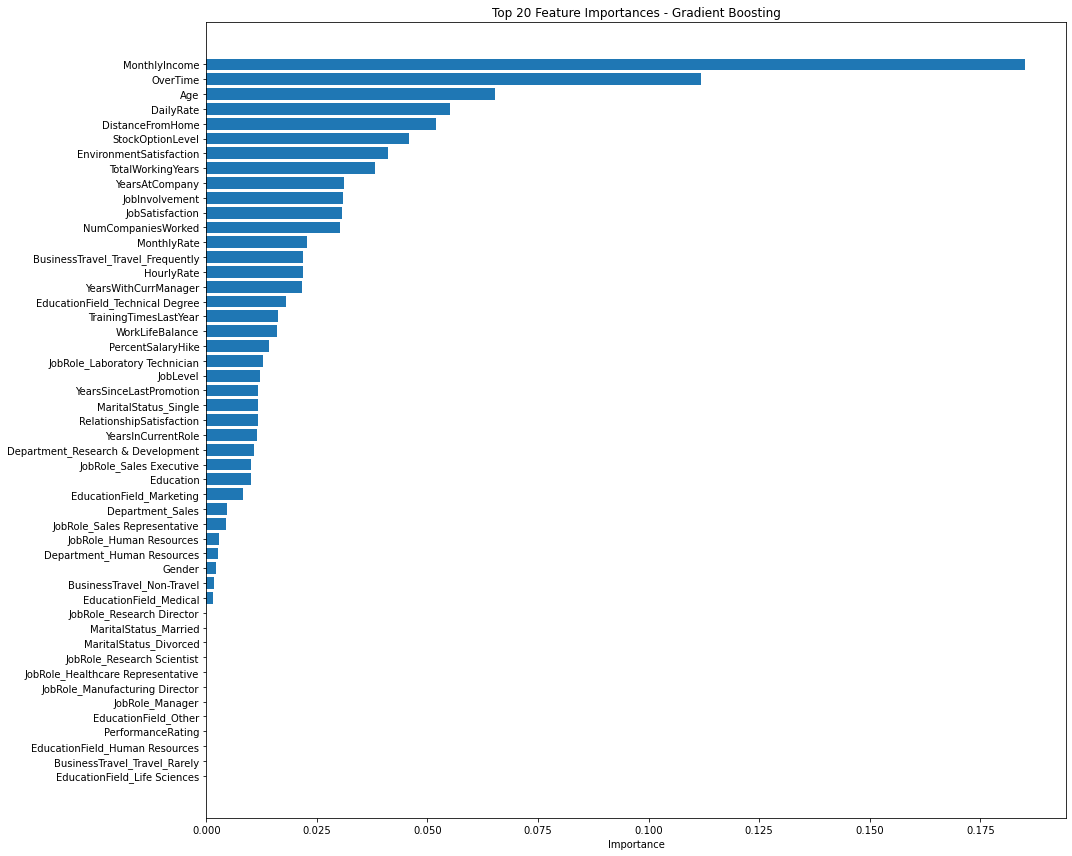

In [90]:
feature_importance_df = get_feature_importance_df(model_5, preprocessor)

# Plot
plt.figure(figsize=(15, 12))
plt.barh(feature_importance_df['Feature'][::-1], feature_importance_df['Importance'][::-1])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances - Gradient Boosting')
plt.tight_layout()
plt.show()

* We can expect the odds of workers who left to increase (the original coeff was positive) for almost all features.
* PerformanceRating, EducationField_Life Sciences,
BusinessTravel_Travel Rarely, EducationField_Human Resources,
JobRole_Manager,
JobRole_Healthcare Representative, EducationField_Other,
JobRole_Manufacturing Director,
JobRole_Research Scientist,
JobRole_Research Director,
MaritalStatus_Divorced,
MaritalStatus_Married have coefficients equal to zero.
* MontlyIncome and OverTime are the strongest predictors.

In [91]:
# Gather some metrics for future comparison of models performance
metrics_5 = compute_classification_metrics(y_train, y_pred_tr, y_test, y_pred)

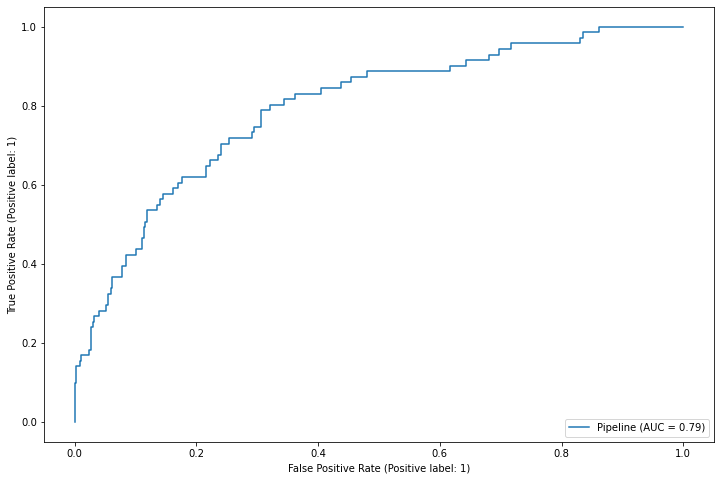

In [92]:
# ROC curve
plot_roc_curve(model_5, X_test, y_test)

AUC is 0.80 which means that there is a 80% chance that the model will be able to distinguish between positive class and negative class.

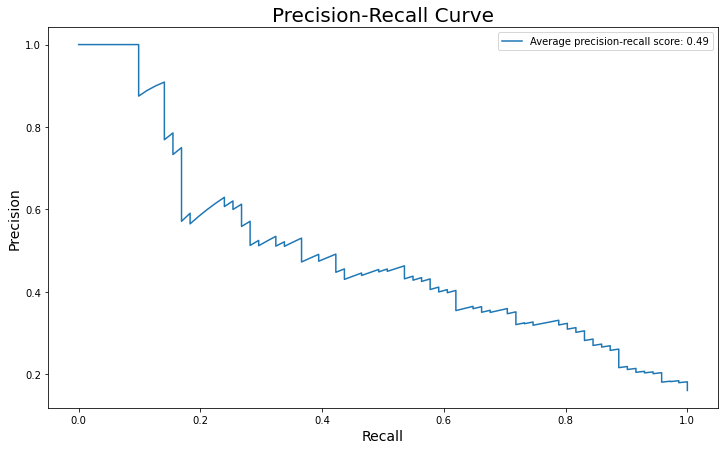

In [93]:
# Precision-Recall curve
plot_precision_recall_curve(model_5, X_test, y_test)

In [94]:
# Row with model
row_5 = create_model_summary_row("Gradient Boosting", metrics_5)

## **XGBoosing model**

Confusion matrix for train set: 


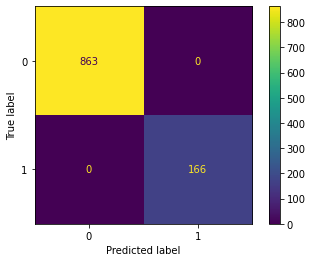

In [95]:
# XGB model
model_6 = get_model_pipeline(XGBClassifier())
model_6.fit(X_train, y_train)

# Model performance evaluation for test and train set
y_pred = model_6.predict(X_test)
y_pred_tr = model_6.predict(X_train)

# Confusion matrix for train set
print("Confusion matrix for train set: ")
ConfusionMatrixDisplay.from_estimator(model_6, X_train, y_train)

Confusion matrix for test set: 


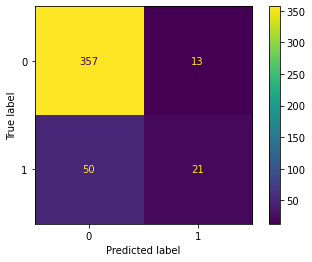

In [96]:
# Confusion matrix for test set
print("Confusion matrix for test set: ")
ConfusionMatrixDisplay.from_estimator(model_6, X_test, y_test)

In [97]:
# Classification report for test set
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       370
           1       0.62      0.30      0.40        71

    accuracy                           0.86       441
   macro avg       0.75      0.63      0.66       441
weighted avg       0.84      0.86      0.84       441



In [98]:
# Classification report for train set
print(classification_report(y_train, y_pred_tr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       863
           1       1.00      1.00      1.00       166

    accuracy                           1.00      1029
   macro avg       1.00      1.00      1.00      1029
weighted avg       1.00      1.00      1.00      1029



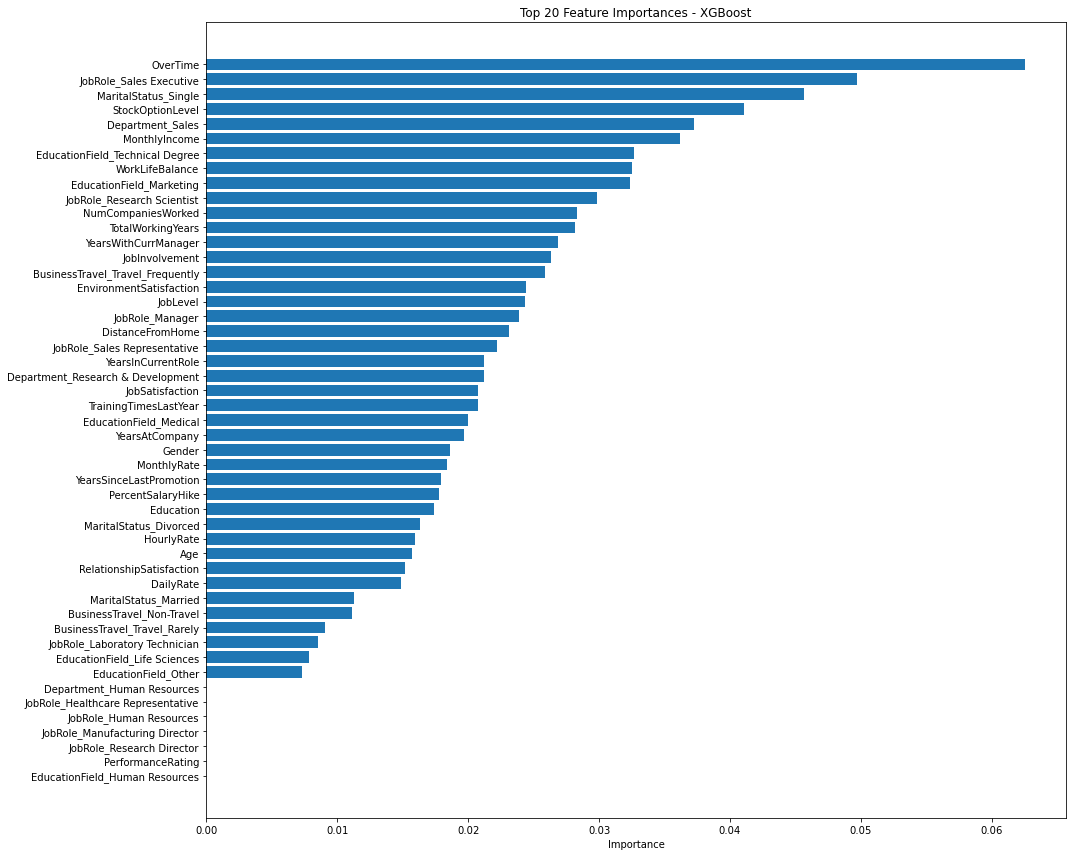

In [99]:
feature_importance_df = get_feature_importance_df(model_6, preprocessor)

# Plot
plt.figure(figsize=(15, 12))
plt.barh(feature_importance_df['Feature'][::-1], feature_importance_df['Importance'][::-1])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances - XGBoost')
plt.tight_layout()
plt.show()

* We can expect the odds of people who left to increase (the original coeff was positive) for almost all features.
* PerformanceRating, EducationField_Human Resources, Department_Human Resources, JobRole_Healthcare Representative, JobRole_Human Resources, JobRole_Manufacturing Director and JobRole_Research Director have coefficients equal to zero.
* Overtime and JobRole_Sales Executive are the strongest predictors.

In [100]:
# Gather some metrics for future comparison of models performance
metrics_6 = compute_classification_metrics(y_train, y_pred_tr, y_test, y_pred)

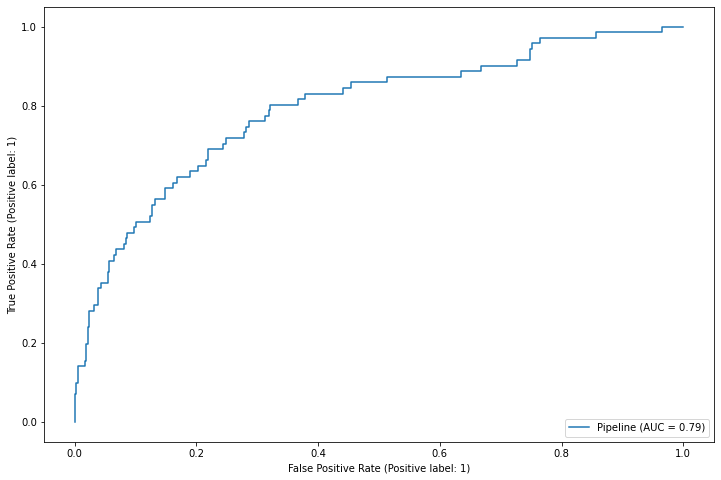

In [101]:
# ROC curve
plot_roc_curve(model_6, X_test, y_test)

AUC is 0.79 which means that there is a 79% chance that the model will be able to distinguish between positive class and negative class.

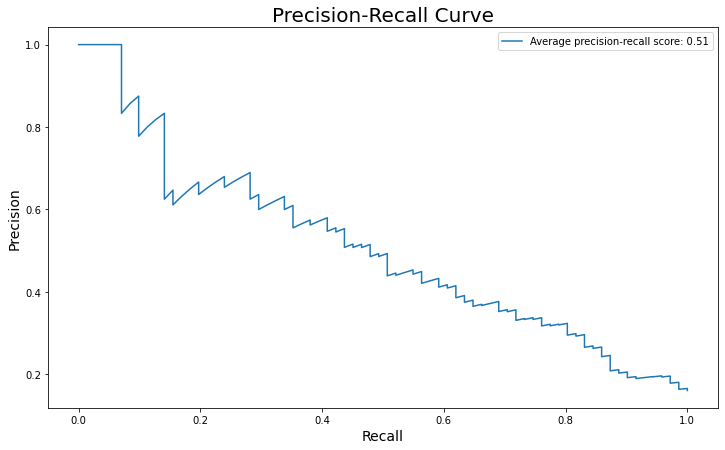

In [102]:
# Precision-Recall curve
plot_precision_recall_curve(model_6, X_test, y_test)

In [103]:
# Row with model
row_6 = create_model_summary_row("XG Boosting", metrics_6)

## **CatBoost model**

In [104]:
# CatBoost classifier model
model_7 = get_model_pipeline(CatBoostClassifier())
model_7.fit(X_train, y_train)

# Model performance evaluation for test and train set
y_pred = model_7.predict(X_test)
y_pred_tr = model_7.predict(X_train)

Learning rate set to 0.010429
0:	learn: 0.6850725	total: 172ms	remaining: 2m 51s
1:	learn: 0.6769945	total: 175ms	remaining: 1m 27s
2:	learn: 0.6703725	total: 179ms	remaining: 59.3s
3:	learn: 0.6628185	total: 183ms	remaining: 45.5s
4:	learn: 0.6564501	total: 186ms	remaining: 37.1s
5:	learn: 0.6497075	total: 190ms	remaining: 31.4s
6:	learn: 0.6434945	total: 193ms	remaining: 27.4s
7:	learn: 0.6363787	total: 196ms	remaining: 24.4s
8:	learn: 0.6294561	total: 200ms	remaining: 22s
9:	learn: 0.6240257	total: 203ms	remaining: 20.1s
10:	learn: 0.6187167	total: 207ms	remaining: 18.6s
11:	learn: 0.6127126	total: 211ms	remaining: 17.4s
12:	learn: 0.6059208	total: 215ms	remaining: 16.3s
13:	learn: 0.6015605	total: 217ms	remaining: 15.3s
14:	learn: 0.5960101	total: 220ms	remaining: 14.5s
15:	learn: 0.5894462	total: 224ms	remaining: 13.8s
16:	learn: 0.5844314	total: 228ms	remaining: 13.2s
17:	learn: 0.5796561	total: 231ms	remaining: 12.6s
18:	learn: 0.5732973	total: 235ms	remaining: 12.1s
19:	learn: 

190:	learn: 0.2848425	total: 856ms	remaining: 3.62s
191:	learn: 0.2842807	total: 859ms	remaining: 3.62s
192:	learn: 0.2837778	total: 863ms	remaining: 3.61s
193:	learn: 0.2832549	total: 866ms	remaining: 3.6s
194:	learn: 0.2825240	total: 870ms	remaining: 3.59s
195:	learn: 0.2818267	total: 873ms	remaining: 3.58s
196:	learn: 0.2814644	total: 876ms	remaining: 3.57s
197:	learn: 0.2809486	total: 881ms	remaining: 3.57s
198:	learn: 0.2802306	total: 884ms	remaining: 3.56s
199:	learn: 0.2794965	total: 888ms	remaining: 3.55s
200:	learn: 0.2789728	total: 891ms	remaining: 3.54s
201:	learn: 0.2784554	total: 894ms	remaining: 3.53s
202:	learn: 0.2779534	total: 898ms	remaining: 3.52s
203:	learn: 0.2774745	total: 902ms	remaining: 3.52s
204:	learn: 0.2768056	total: 905ms	remaining: 3.51s
205:	learn: 0.2760342	total: 909ms	remaining: 3.5s
206:	learn: 0.2755065	total: 912ms	remaining: 3.49s
207:	learn: 0.2750813	total: 916ms	remaining: 3.49s
208:	learn: 0.2744984	total: 919ms	remaining: 3.48s
209:	learn: 0.

385:	learn: 0.2092887	total: 1.54s	remaining: 2.46s
386:	learn: 0.2091056	total: 1.55s	remaining: 2.45s
387:	learn: 0.2088928	total: 1.55s	remaining: 2.45s
388:	learn: 0.2085750	total: 1.55s	remaining: 2.44s
389:	learn: 0.2083496	total: 1.56s	remaining: 2.44s
390:	learn: 0.2081111	total: 1.56s	remaining: 2.43s
391:	learn: 0.2078774	total: 1.56s	remaining: 2.43s
392:	learn: 0.2076775	total: 1.57s	remaining: 2.42s
393:	learn: 0.2074181	total: 1.57s	remaining: 2.42s
394:	learn: 0.2071458	total: 1.57s	remaining: 2.41s
395:	learn: 0.2069730	total: 1.58s	remaining: 2.41s
396:	learn: 0.2067176	total: 1.58s	remaining: 2.4s
397:	learn: 0.2064897	total: 1.58s	remaining: 2.4s
398:	learn: 0.2062851	total: 1.59s	remaining: 2.39s
399:	learn: 0.2060340	total: 1.59s	remaining: 2.39s
400:	learn: 0.2056072	total: 1.6s	remaining: 2.38s
401:	learn: 0.2054062	total: 1.6s	remaining: 2.38s
402:	learn: 0.2051798	total: 1.6s	remaining: 2.38s
403:	learn: 0.2048972	total: 1.61s	remaining: 2.38s
404:	learn: 0.204

584:	learn: 0.1629509	total: 2.23s	remaining: 1.58s
585:	learn: 0.1627662	total: 2.23s	remaining: 1.58s
586:	learn: 0.1625322	total: 2.24s	remaining: 1.57s
587:	learn: 0.1622492	total: 2.24s	remaining: 1.57s
588:	learn: 0.1620401	total: 2.25s	remaining: 1.57s
589:	learn: 0.1617104	total: 2.25s	remaining: 1.56s
590:	learn: 0.1615150	total: 2.25s	remaining: 1.56s
591:	learn: 0.1612800	total: 2.25s	remaining: 1.55s
592:	learn: 0.1611371	total: 2.26s	remaining: 1.55s
593:	learn: 0.1607798	total: 2.26s	remaining: 1.55s
594:	learn: 0.1605841	total: 2.27s	remaining: 1.54s
595:	learn: 0.1604409	total: 2.27s	remaining: 1.54s
596:	learn: 0.1601952	total: 2.27s	remaining: 1.53s
597:	learn: 0.1598747	total: 2.28s	remaining: 1.53s
598:	learn: 0.1596936	total: 2.28s	remaining: 1.53s
599:	learn: 0.1594869	total: 2.28s	remaining: 1.52s
600:	learn: 0.1592866	total: 2.29s	remaining: 1.52s
601:	learn: 0.1590835	total: 2.29s	remaining: 1.51s
602:	learn: 0.1587632	total: 2.29s	remaining: 1.51s
603:	learn: 

782:	learn: 0.1261645	total: 2.92s	remaining: 809ms
783:	learn: 0.1259858	total: 2.92s	remaining: 805ms
784:	learn: 0.1258468	total: 2.93s	remaining: 802ms
785:	learn: 0.1256676	total: 2.93s	remaining: 798ms
786:	learn: 0.1255954	total: 2.93s	remaining: 794ms
787:	learn: 0.1253675	total: 2.94s	remaining: 790ms
788:	learn: 0.1252029	total: 2.94s	remaining: 786ms
789:	learn: 0.1249952	total: 2.94s	remaining: 783ms
790:	learn: 0.1247842	total: 2.95s	remaining: 779ms
791:	learn: 0.1245609	total: 2.95s	remaining: 775ms
792:	learn: 0.1244220	total: 2.95s	remaining: 771ms
793:	learn: 0.1243732	total: 2.96s	remaining: 767ms
794:	learn: 0.1242536	total: 2.96s	remaining: 763ms
795:	learn: 0.1241710	total: 2.96s	remaining: 760ms
796:	learn: 0.1241085	total: 2.97s	remaining: 756ms
797:	learn: 0.1238616	total: 2.97s	remaining: 752ms
798:	learn: 0.1238191	total: 2.97s	remaining: 748ms
799:	learn: 0.1236641	total: 2.98s	remaining: 744ms
800:	learn: 0.1234748	total: 2.98s	remaining: 741ms
801:	learn: 

981:	learn: 0.0968567	total: 3.61s	remaining: 66.2ms
982:	learn: 0.0967014	total: 3.61s	remaining: 62.5ms
983:	learn: 0.0965683	total: 3.62s	remaining: 58.8ms
984:	learn: 0.0964138	total: 3.62s	remaining: 55.1ms
985:	learn: 0.0962465	total: 3.62s	remaining: 51.4ms
986:	learn: 0.0960908	total: 3.63s	remaining: 47.8ms
987:	learn: 0.0959604	total: 3.63s	remaining: 44.1ms
988:	learn: 0.0958214	total: 3.63s	remaining: 40.4ms
989:	learn: 0.0957408	total: 3.64s	remaining: 36.7ms
990:	learn: 0.0955601	total: 3.64s	remaining: 33.1ms
991:	learn: 0.0954584	total: 3.64s	remaining: 29.4ms
992:	learn: 0.0953449	total: 3.65s	remaining: 25.7ms
993:	learn: 0.0951996	total: 3.65s	remaining: 22ms
994:	learn: 0.0951304	total: 3.65s	remaining: 18.4ms
995:	learn: 0.0949715	total: 3.66s	remaining: 14.7ms
996:	learn: 0.0947830	total: 3.66s	remaining: 11ms
997:	learn: 0.0946459	total: 3.66s	remaining: 7.34ms
998:	learn: 0.0945570	total: 3.67s	remaining: 3.67ms
999:	learn: 0.0944491	total: 3.67s	remaining: 0us


Confusion matrix for train set: 


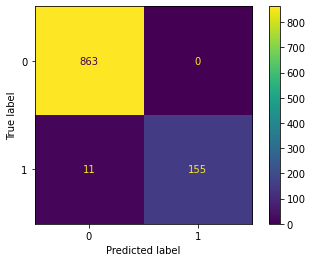

In [105]:
# Confusion matrix for train set
print("Confusion matrix for train set: ")
ConfusionMatrixDisplay.from_estimator(model_7, X_train, y_train)

Confusion matrix for test set: 


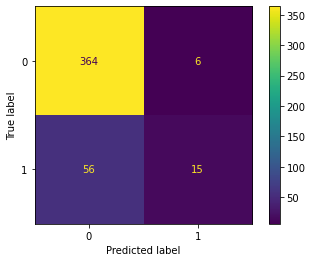

In [106]:
# Confusion matrix for test set
print("Confusion matrix for test set: ")
ConfusionMatrixDisplay.from_estimator(model_7, X_test, y_test)

In [107]:
# Classification report for test set
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92       370
           1       0.71      0.21      0.33        71

    accuracy                           0.86       441
   macro avg       0.79      0.60      0.62       441
weighted avg       0.84      0.86      0.83       441



In [108]:
# Classification report for train set
print(classification_report(y_train, y_pred_tr))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       863
           1       1.00      0.93      0.97       166

    accuracy                           0.99      1029
   macro avg       0.99      0.97      0.98      1029
weighted avg       0.99      0.99      0.99      1029



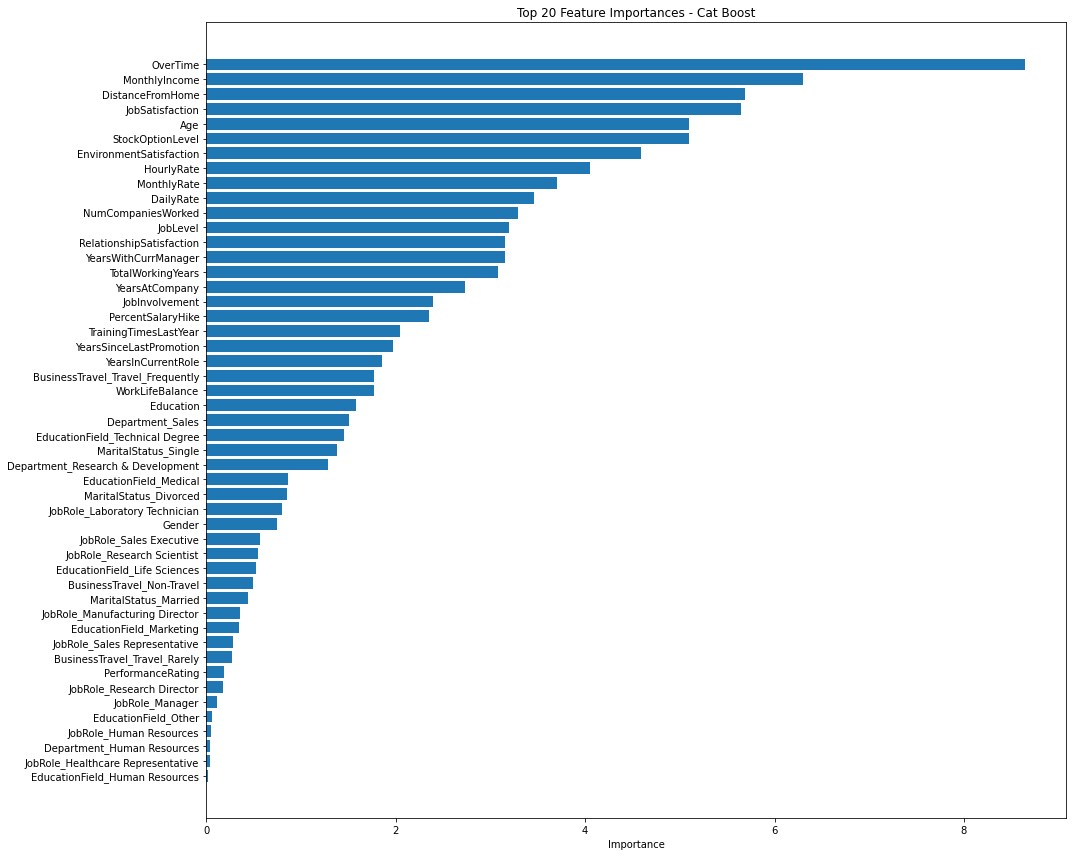

In [109]:
feature_importance_df = get_feature_importance_df(model_7, preprocessor)

# Plot
plt.figure(figsize=(15, 12))
plt.barh(feature_importance_df['Feature'][::-1], feature_importance_df['Importance'][::-1])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances - Cat Boost')
plt.tight_layout()
plt.show()

* We can expect the odds of people who left to increase (the original coeff was positive) for almost all features.
* OverTime, MonthlyIncome and DistanceFromHome are the strongest predictors.

In [110]:
# Gather some metrics for future comparison of models performance
metrics_7 = compute_classification_metrics(y_train, y_pred_tr, y_test, y_pred)

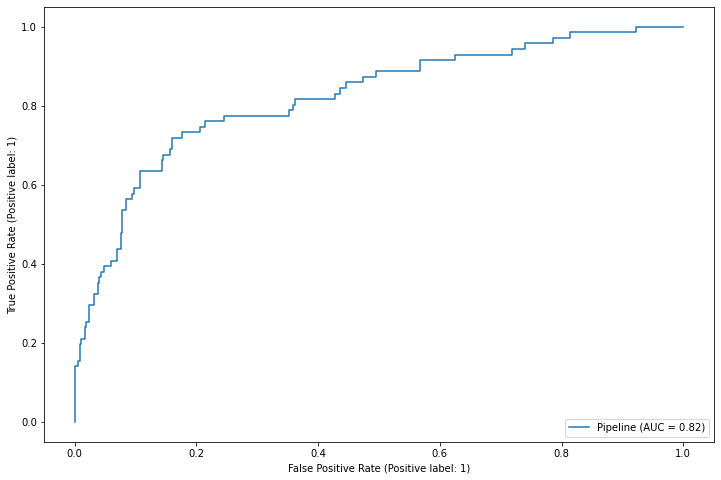

In [111]:
# ROC curve
plot_roc_curve(model_7, X_test, y_test)

AUC is 0.82 which means that there is a 82% chance that the model will be able to distinguish between positive class and negative class.

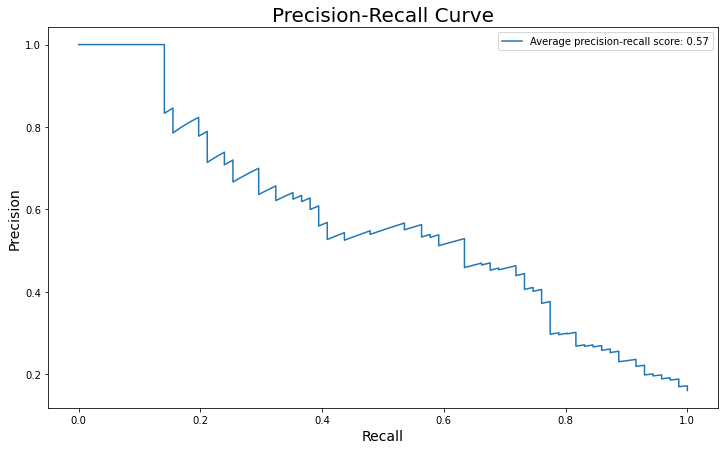

In [112]:
# Precision-Recall curve
plot_precision_recall_curve(model_7, X_test, y_test)

In [113]:
# Row with model
row_7 = create_model_summary_row("CatBoost", metrics_7)

## **Model summary**

In [114]:
# Add all results to dataframe
results = pd.DataFrame(columns=['model', 'tp', 'tn', 'fp', 'fn', 'correct', 'incorrect',
                                  'accuracy_train', 'accuracy_test', 'precision_train', 'precision_test', 'recall_train', 'recall_test', 'f1_train', 'f1_test', 'roc_auc', 'avg_pre'])
new_rows = pd.DataFrame([row_1, row_2, row_3, row_4, row_5, row_6, row_7])
results = pd.concat([results, new_rows], ignore_index=True)
results

,model,tp,tn,fp,fn,correct,incorrect,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,roc_auc,avg_pre
0,Logistic Regression,35,358,12,36,393,48,0.893100,0.891156,0.811111,0.744681,0.439759,0.492958,0.570312,0.593220,0.730263,0.449
1,Random Forest,15,368,2,56,383,58,1.000000,0.868481,1.000000,0.882353,1.000000,0.211268,1.000000,0.340909,0.602931,0.313
2,Decision Tree,21,312,58,50,333,108,1.000000,0.755102,1.000000,0.265823,1.000000,0.295775,1.000000,0.280000,0.569509,0.192
3,Ada Boost,32,355,15,39,387,54,0.913508,0.877551,0.888889,0.680851,0.530120,0.450704,0.664151,0.542373,0.705082,0.395
4,Gradient Boosting,18,358,12,53,376,65,0.960155,0.852608,0.992126,0.600000,0.759036,0.253521,0.860068,0.356436,0.610544,0.272
5,XG Boosting,21,357,13,50,378,63,1.000000,0.857143,1.000000,0.617647,1.000000,0.295775,1.000000,0.400000,0.630320,0.296
6,CatBoost,15,364,6,56,379,62,0.989310,0.859410,1.000000,0.714286,0.933735,0.211268,0.965732,0.326087,0.597526,0.278


## **Genaral overwiew of models**

* Logistic Regression performs the best overall with a strong balance between precision of 0.74 and recall of 0.49, making it the most robust choice. It is well-suited for imbalanced classification with minimal overfitting.

* Random Forest is overfitting—perfect precision on train (100%) and almost on test set (0.88), but almost no true positives captured (low recal of 0.21l). Poor generalization and poor F1 of 0.34.

* Single tree is underperforming. Although interpretable, it lacks predictive power and likely overfits (precision and accuracy on train set equal 100%).

* AdaBoost is precise but fails to capture actual attrition cases (medium recall of 0.45). Performs better than Random Forest but worse than Logistic Regression.

* Gradient Boosting - decent recall of 0.35 and ROC AUC of 0.61, better than AdaBoost, but still significantly underperforms compared to Logistic Regression. Potential for improvement with tuning.

* XGBoost shows promise—balanced performance and worse recall than AdaBoost (0.29 vs 0.45). Still trails behind Logistic Regression in F1 of 0.4 and ROC AUC of 0.63.

* CatBoost is stable and good at precision but lacks strong recall (0.21). Similar to AdaBoost and Gradient Boosting.

# **To sum up, Logistic Regression will be taken into account in further analysis.**


# **Logistic regression with undersampling**

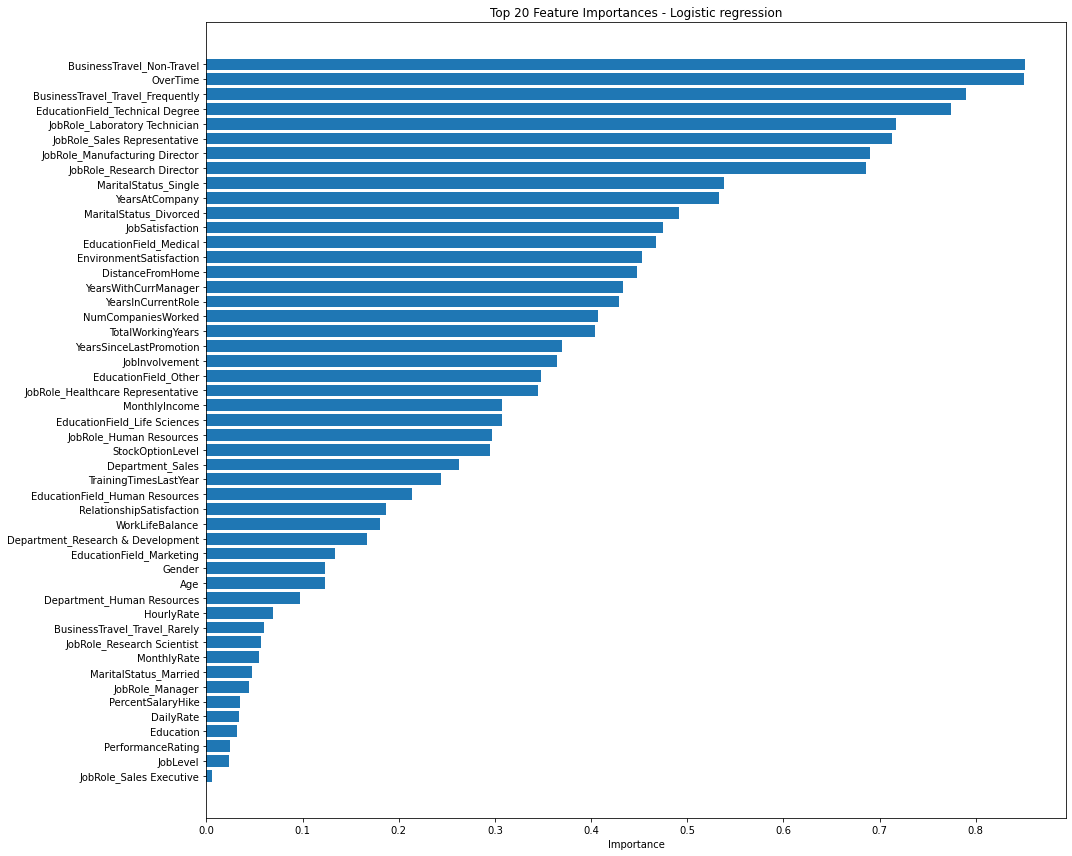

In [115]:
feature_names = []

# Extract feature names from each transformer in the ColumnTransformer
for name, transformer, columns in preprocessor.transformers_:
    if name != 'remainder':
        if hasattr(transformer, 'get_feature_names_out'):
            transformed_names = transformer.get_feature_names_out(columns)
        else:
            transformed_names = columns
        feature_names.extend(transformed_names)

m1 = model_1.named_steps['model']
importances = abs(m1.coef_[0])

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(15, 12))
plt.barh(feature_importance_df['Feature'][::-1], feature_importance_df['Importance'][::-1])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances - Logistic regression')
plt.tight_layout()
plt.show()

In [116]:
# For further analysis, only the numerical features with the greatest positive feature importance will be be used: 'OverTime', 'YearsAtCompany', 'JobSatisfaction', 'EnvironmentSatisfaction', 'DistanceFromHome', 'YearsWithCurrManager', 'YearsInCurrentRole', 'NumCompaniesWorked', 'TotalWorkingYears', 'YearsSinceLastPromotion'
# All categorical features will be considered
num_shrink =['OverTime', 'YearsAtCompany', 'JobSatisfaction', 'EnvironmentSatisfaction', 'DistanceFromHome', 'YearsWithCurrManager', 'YearsInCurrentRole', 'NumCompaniesWorked', 'TotalWorkingYears', 'YearsSinceLastPromotion']
attr = list(num_shrink) + list(cat_attr)

In [117]:
preprocessor_shrink = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_shrink),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_attr_shrink)
])

In [118]:
X_train_top = X_train[attr]
X_test_top = X_test[attr]

In [119]:
undersample_pipeline = ImbPipeline(steps=[
    ("preprocessing", preprocessor_shrink),
    ("undersample", RandomUnderSampler(random_state=42)),
    ("model", LogisticRegression())
])

Confusion matrix for train set: 


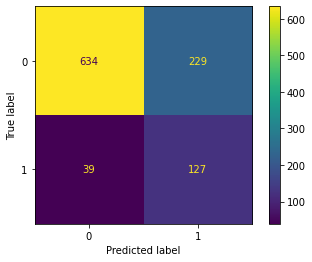

In [120]:
# Logistic regression model
undersample_pipeline.fit(X_train_top, y_train)

# Model performance evaluation for test and train set
y_pred = undersample_pipeline.predict(X_test_top)
y_pred_tr = undersample_pipeline.predict(X_train_top)

# Confusion matrix for train set
print("Confusion matrix for train set: ")
ConfusionMatrixDisplay.from_estimator(undersample_pipeline, X_train_top, y_train)

Confusion matrix for test set: 


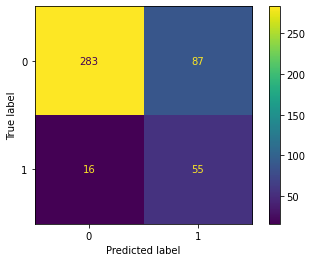

In [121]:
# Confusion matrix for test set
print("Confusion matrix for test set: ")
ConfusionMatrixDisplay.from_estimator(undersample_pipeline, X_test_top, y_test)

In [122]:
# Classification report for test set
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.76      0.85       370
           1       0.39      0.77      0.52        71

    accuracy                           0.77       441
   macro avg       0.67      0.77      0.68       441
weighted avg       0.86      0.77      0.79       441



In [123]:
# Classification report for train set
print(classification_report(y_train, y_pred_tr))

              precision    recall  f1-score   support

           0       0.94      0.73      0.83       863
           1       0.36      0.77      0.49       166

    accuracy                           0.74      1029
   macro avg       0.65      0.75      0.66      1029
weighted avg       0.85      0.74      0.77      1029



In [124]:
# Gather some metrics for future comparison of models performance
metrics_8 = compute_classification_metrics(y_train, y_pred_tr, y_test, y_pred)

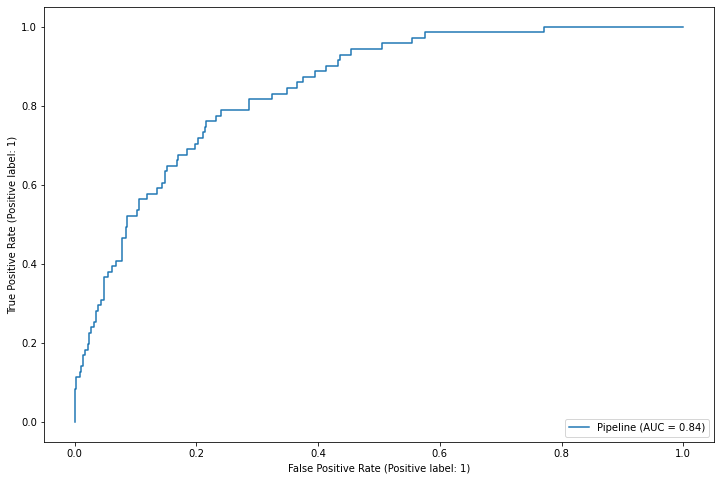

In [125]:
# ROC curve
plot_roc_curve(undersample_pipeline, X_test, y_test)

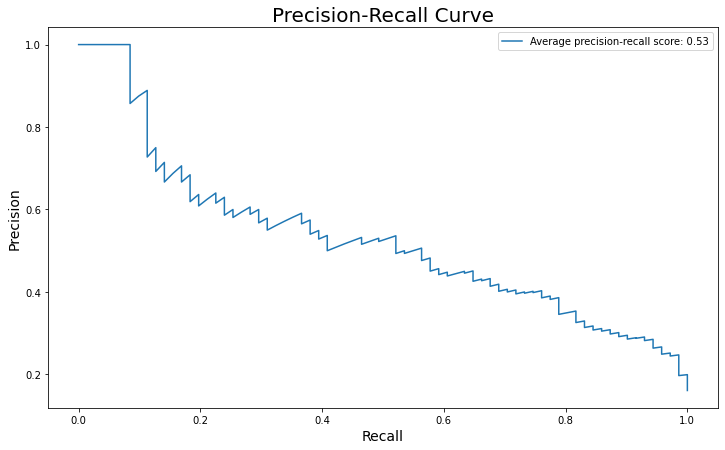

In [126]:
# Precision-Recall curve
plot_precision_recall_curve(undersample_pipeline, X_test, y_test)

In [127]:
# Row with model
row_8 = create_model_summary_row("Logistic regression with undersampling", metrics_8)

# **Logistic Regression with oversampling**

In [128]:
oversample_pipeline = ImbPipeline(steps=[
    ("preprocessing", preprocessor_shrink),
    ("oversample", RandomOverSampler(random_state=42)),
    ("model", LogisticRegression())
])

Confusion matrix for train set: 


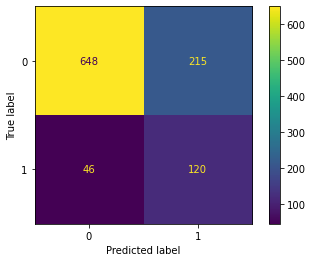

In [129]:
# Logistic regression model
oversample_pipeline.fit(X_train_top, y_train)

# Model performance evaluation for test and train set
y_pred = oversample_pipeline.predict(X_test_top)
y_pred_tr = oversample_pipeline.predict(X_train_top)

# Confusion matrix for train set
print("Confusion matrix for train set: ")
ConfusionMatrixDisplay.from_estimator(oversample_pipeline, X_train_top, y_train)

Confusion matrix for test set: 


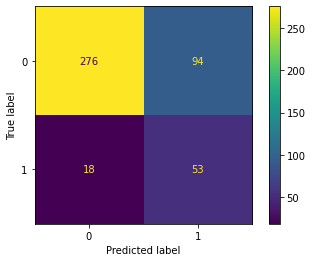

In [130]:
# Confusion matrix for test set
print("Confusion matrix for test set: ")
ConfusionMatrixDisplay.from_estimator(oversample_pipeline, X_test_top, y_test)

In [131]:
# Classification report for test set
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.75      0.83       370
           1       0.36      0.75      0.49        71

    accuracy                           0.75       441
   macro avg       0.65      0.75      0.66       441
weighted avg       0.85      0.75      0.78       441



In [132]:
# Classification report for train set
print(classification_report(y_train, y_pred_tr))

              precision    recall  f1-score   support

           0       0.93      0.75      0.83       863
           1       0.36      0.72      0.48       166

    accuracy                           0.75      1029
   macro avg       0.65      0.74      0.66      1029
weighted avg       0.84      0.75      0.78      1029



In [133]:
# Gather some metrics for future comparison of models performance
metrics_9 = compute_classification_metrics(y_train, y_pred_tr, y_test, y_pred)

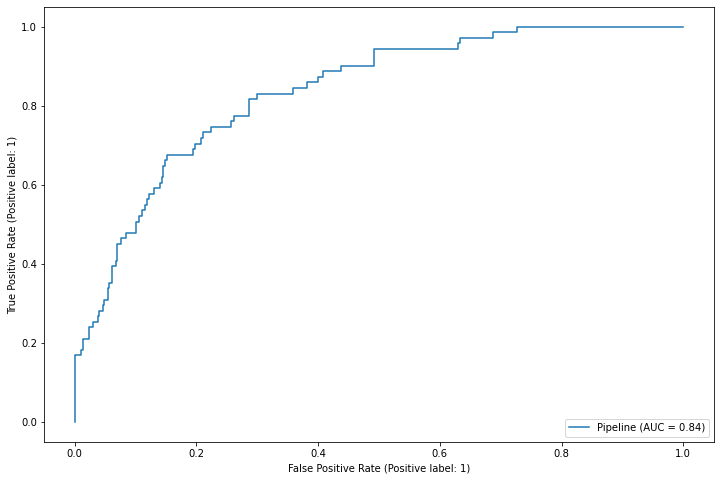

In [134]:
# ROC curve
plot_roc_curve(oversample_pipeline, X_test, y_test)

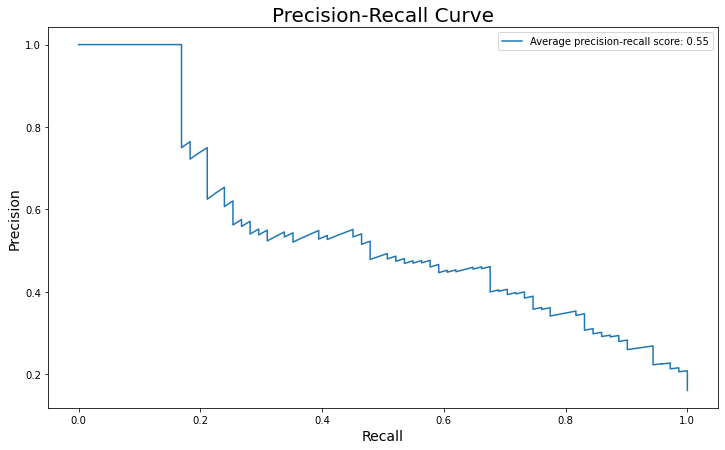

In [135]:
# Precision-Recall curve
plot_precision_recall_curve(oversample_pipeline, X_test, y_test)

In [136]:
# Row with model
row_9 = create_model_summary_row("Logistic regression with oversampling", metrics_9)

# **Logistic regression with SMOTE**

In [137]:
smote_pipeline = ImbPipeline(steps=[
    ("preprocessing", preprocessor_shrink),
    ("smote", SMOTE(random_state=42)),
    ("model", LogisticRegression())
])

Confusion matrix for train set: 


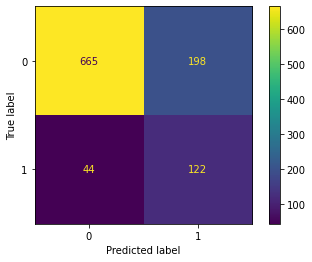

In [138]:
#Logistic regression model
smote_pipeline.fit(X_train_top, y_train)

# Model performance evaluation for test and train set
y_pred = smote_pipeline.predict(X_test_top)
y_pred_tr = smote_pipeline.predict(X_train_top)

# Confusion matrix for train set
print("Confusion matrix for train set: ")
ConfusionMatrixDisplay.from_estimator(smote_pipeline, X_train_top, y_train)

Confusion matrix for test set: 


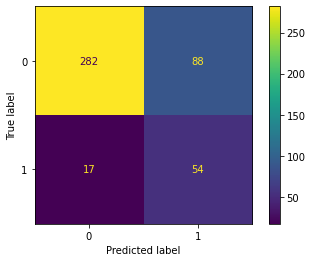

In [139]:
# Confusion matrix for test set
print("Confusion matrix for test set: ")
ConfusionMatrixDisplay.from_estimator(smote_pipeline, X_test_top, y_test)

In [140]:
# Classification report for test set
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.76      0.84       370
           1       0.38      0.76      0.51        71

    accuracy                           0.76       441
   macro avg       0.66      0.76      0.68       441
weighted avg       0.85      0.76      0.79       441



In [141]:
# Classification report for train set
print(classification_report(y_train, y_pred_tr))

              precision    recall  f1-score   support

           0       0.94      0.77      0.85       863
           1       0.38      0.73      0.50       166

    accuracy                           0.76      1029
   macro avg       0.66      0.75      0.67      1029
weighted avg       0.85      0.76      0.79      1029



In [142]:
# Gather some metrics for future comparison of models performance
metrics_10 = compute_classification_metrics(y_train, y_pred_tr, y_test, y_pred)

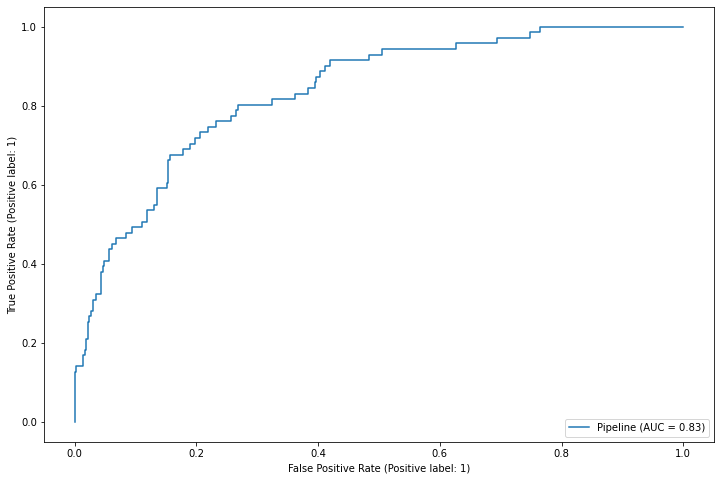

In [143]:
# ROC curve
plot_roc_curve(smote_pipeline, X_test, y_test)

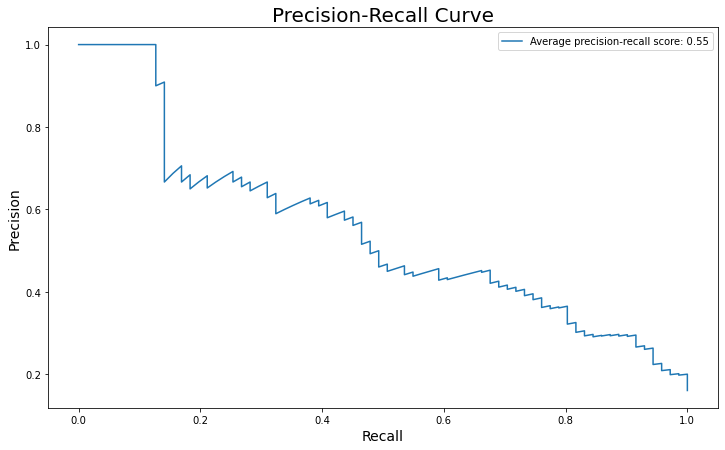

In [144]:
# Precision-Recall curve
plot_precision_recall_curve(smote_pipeline, X_test, y_test)

In [145]:
# Row with model
row_10 = create_model_summary_row("Logistic regression with SMOTE", metrics_10)

## **Best model summary**

In [146]:
new_rows = pd.DataFrame([row_8, row_9, row_10])
results = pd.concat([results, new_rows], ignore_index=True)
results

,model,tp,tn,fp,fn,correct,incorrect,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,roc_auc,avg_pre
0,Logistic Regression,35,358,12,36,393,48,0.893100,0.891156,0.811111,0.744681,0.439759,0.492958,0.570312,0.593220,0.730263,0.449
1,Random Forest,15,368,2,56,383,58,1.000000,0.868481,1.000000,0.882353,1.000000,0.211268,1.000000,0.340909,0.602931,0.313
2,Decision Tree,21,312,58,50,333,108,1.000000,0.755102,1.000000,0.265823,1.000000,0.295775,1.000000,0.280000,0.569509,0.192
3,Ada Boost,32,355,15,39,387,54,0.913508,0.877551,0.888889,0.680851,0.530120,0.450704,0.664151,0.542373,0.705082,0.395
4,Gradient Boosting,18,358,12,53,376,65,0.960155,0.852608,0.992126,0.600000,0.759036,0.253521,0.860068,0.356436,0.610544,0.272
5,XG Boosting,21,357,13,50,378,63,1.000000,0.857143,1.000000,0.617647,1.000000,0.295775,1.000000,0.400000,0.630320,0.296
6,CatBoost,15,364,6,56,379,62,0.989310,0.859410,1.000000,0.714286,0.933735,0.211268,0.965732,0.326087,0.597526,0.278
7,Logistic regression with undersampling,55,283,87,16,338,103,0.739553,0.766440,0.356742,0.387324,0.765060,0.774648,0.486590,0.516432,0.769756,0.336
8,Logistic regression with oversampling,53,276,94,18,329,112,0.746356,0.746032,0.358209,0.360544,0.722892,0.746479,0.479042,0.486239,0.746212,0.310
9,Logistic regression with SMOTE,54,282,88,17,336,105,0.764820,0.761905,0.381250,0.380282,0.734940,0.760563,0.502058,0.507042,0.761363,0.328


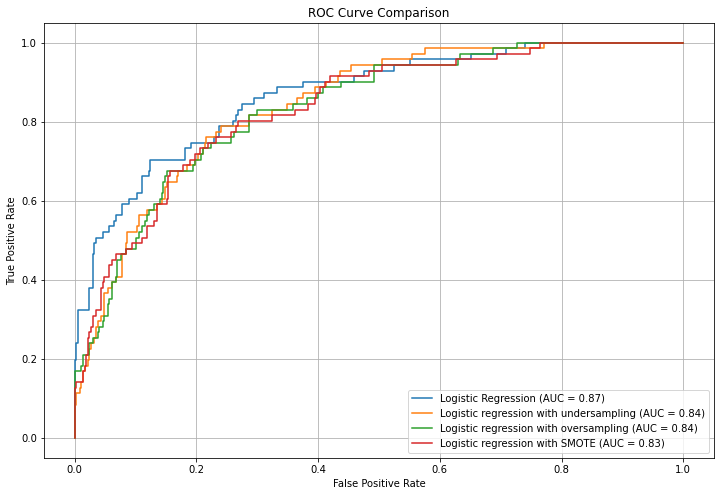

In [147]:
# Roc for all mogistic regression models
models = models = {
    "Logistic Regression": model_1,
    "Logistic regression with undersampling": undersample_pipeline,
    "Logistic regression with oversampling": oversample_pipeline,
    "Logistic regression with SMOTE": smote_pipeline
}
plt.figure(figsize=(12, 8))
for name, model in models.items():
    RocCurveDisplay.from_estimator(model, X_test, y_test, name=name, ax=plt.gca())
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

**Models summary**

* Baseline Logistic regression model has the highest test accuracy of 0.89, highest precision of 0.74 and F1 score of 0.59. It has good ROC AUC (73%) and average precision (46%). The drawback is that the recall is lowest (49%) - misses more positive cases than others.
* Undersampling model has the highest recall (76%) but the poor precision (almost 39%). It has moderate F1 (51%) and highest ROC AUC (almost 77%). Seems to be the best option for maximizing recall.
* Oversampling model results are similar to indersampling model but it has slightly lower performance overall.
* SMOTE model is a balanced option between undersampling and oversampling. It has slightly better precision (38%) and F1 (50%) than oversampling. 

* **Undersampling model** is the best for attrition detection. It has the highest recall - correctly detects almost 78% of attrition cases. It has the best ROC AUC 77%. Althoug it has lower precision of almost 39%, in attrition detection false positives are less harmful than false negatives.

## **Making a predictive system**

In [148]:
input_data = (0, 9, 4, 3, 2, 3, 7, 4, 12, 7, 'Travel_Rarely', 'Sales', 'Medical', 'Sales Executive', 'Single')

# Changing the input_data to numpy array
input_data_as_numpy_array = np.asarray(input_data)

# Reshape the array as we are predicting for one instance
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

example = pd.DataFrame(input_data_reshaped)
example.columns = X_test_top.columns

best_model = undersample_pipeline

prediction = best_model.predict(example)

if (prediction[0] == 0):
  print('The person will stay.')
else:
  print('The person will leave.')

The person will stay.


In [149]:
example.T

,0
OverTime,0
YearsAtCompany,9
JobSatisfaction,4
EnvironmentSatisfaction,3
DistanceFromHome,2
YearsWithCurrManager,3
YearsInCurrentRole,7
NumCompaniesWorked,4
TotalWorkingYears,12
YearsSinceLastPromotion,7


## **Saving the trained model**

In [150]:
filename = './model/trained_model.sav'
pickle.dump(best_model, open(filename, 'wb'))

In [151]:
# loading the saved model
loaded_model = pickle.load(open(filename, 'rb'))

In [152]:
input_data = (1, 9, 4, 3, 2, 3, 7, 4, 12, 7, 'Travel_Rarely', 'Sales', 'Medical', 'Sales Executive', 'Married')

# Changing the input_data to numpy array
input_data_as_numpy_array = np.asarray(input_data)

# reshape the array as we are predicting for one instance
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

example = pd.DataFrame(input_data_reshaped)
example.columns = X_test_top.columns

prediction = loaded_model.predict(example)

if (prediction[0] == 0):
  print('The person will stay.')
else:
  print('The person will leave.')

The person will leave.


In [153]:
example.T

,0
OverTime,1
YearsAtCompany,9
JobSatisfaction,4
EnvironmentSatisfaction,3
DistanceFromHome,2
YearsWithCurrManager,3
YearsInCurrentRole,7
NumCompaniesWorked,4
TotalWorkingYears,12
YearsSinceLastPromotion,7
